# Pre-processing Pipeline

## Generating edges from embedding similarity & direct citations

In [29]:
import pandas as pd
import json

# load the data from your JSON file
with open(r'C:\Users\1kevi\Desktop\projects\Research\autoscious-carbon-capture\data_collection\openalex\extracted_results_with_embeddings.json', 'r') as f:
    data = json.load(f)

# convert the data into a pandas DataFrame
df = pd.DataFrame(data)
df['paperId'] = df['id']
df = df[df['embedding'].apply(lambda x: len(x) != 0)] # drop empty embeddings

# print out the DataFrame to verify
print(df.head())

                                 id                                      doi  \
0  https://openalex.org/W2010971702  https://doi.org/10.1126/science.1157996   
1  https://openalex.org/W2006318126          https://doi.org/10.1038/451652a   
2  https://openalex.org/W2259938310      https://doi.org/10.1038/nature11247   
3  https://openalex.org/W2097255042         https://doi.org/10.1038/35021093   
4  https://openalex.org/W2081693079         https://doi.org/10.1063/1.328693   

                                               title  isOpenAccess  \
0  Measurement of the Elastic Properties and Intr...         False   
1                          Building better batteries         False   
2  An integrated encyclopedia of DNA elements in ...          True   
3        Molecular portraits of human breast tumours         False   
4  Polymorphic transitions in single crystals: A ...         False   

                                            abstract  \
0  We measured the elastic properties and 

In [3]:
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_distances
from sklearn.preprocessing import MinMaxScaler
import json


In [17]:
# Get embedding distances

# Extract 'vector' from 'embedding' and convert to DataFrame
embedding_df = pd.DataFrame(df['embedding'].tolist())
embedding_df = embedding_df.dropna()

# Compute the cosine distances
distances = cosine_distances(embedding_df)

# Initialize a MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 100))

# Reshape distances to a 1D array and scale
distances_scaled = scaler.fit_transform(distances.reshape(-1, 1))

# Reshape back to original shape
distances_scaled = distances_scaled.reshape(distances.shape)


In [20]:
# Initialize lists to store the edges data
source = []
target = []
weights = []

# Iterate over the distances matrix
for i in range(distances.shape[0]):
    for j in range(i+1, distances.shape[1]):  # j starts from i+1 to avoid duplicate edges and self-edges
        source.append(df.iloc[i]['paperId'])
        target.append(df.iloc[j]['paperId'])
        weights.append(distances_scaled[i, j])

# Create the edges DataFrame
edges_df = pd.DataFrame({'id': range(len(source)), 'weight': weights, 'source': source, 'target': target})

# 14m for 2000 nodes

In [21]:
# Convert the DataFrame to a JSON string
edges_json = edges_df.to_json(orient='records', indent=4)

# Dump in JSON
with open('edges/edges_2000.json', 'w') as f:
    f.write(edges_json)

# Convert the JSON string to a dictionary
edges_dict = json.loads(edges_json)


In [36]:
# Code for creating edges based on direct citations
df["citations"]

0       https://api.openalex.org/works?filter=cites:W2...
1       https://api.openalex.org/works?filter=cites:W2...
2       https://api.openalex.org/works?filter=cites:W2...
3       https://api.openalex.org/works?filter=cites:W2...
4       https://api.openalex.org/works?filter=cites:W2...
                              ...                        
1994    https://api.openalex.org/works?filter=cites:W2...
1995    https://api.openalex.org/works?filter=cites:W2...
1996    https://api.openalex.org/works?filter=cites:W1...
1997    https://api.openalex.org/works?filter=cites:W1...
1998    https://api.openalex.org/works?filter=cites:W1...
Name: citations, Length: 1990, dtype: object

## Generating a T-SNE x, y coordinates from embeddings

In [22]:
import pandas as pd
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import textwrap
from adjustText import adjust_text

In [31]:
embeddings = np.vstack(df['embedding'])

In [32]:
tsne = TSNE(n_components=2, random_state=0)
embeddings_2d = tsne.fit_transform(embeddings)


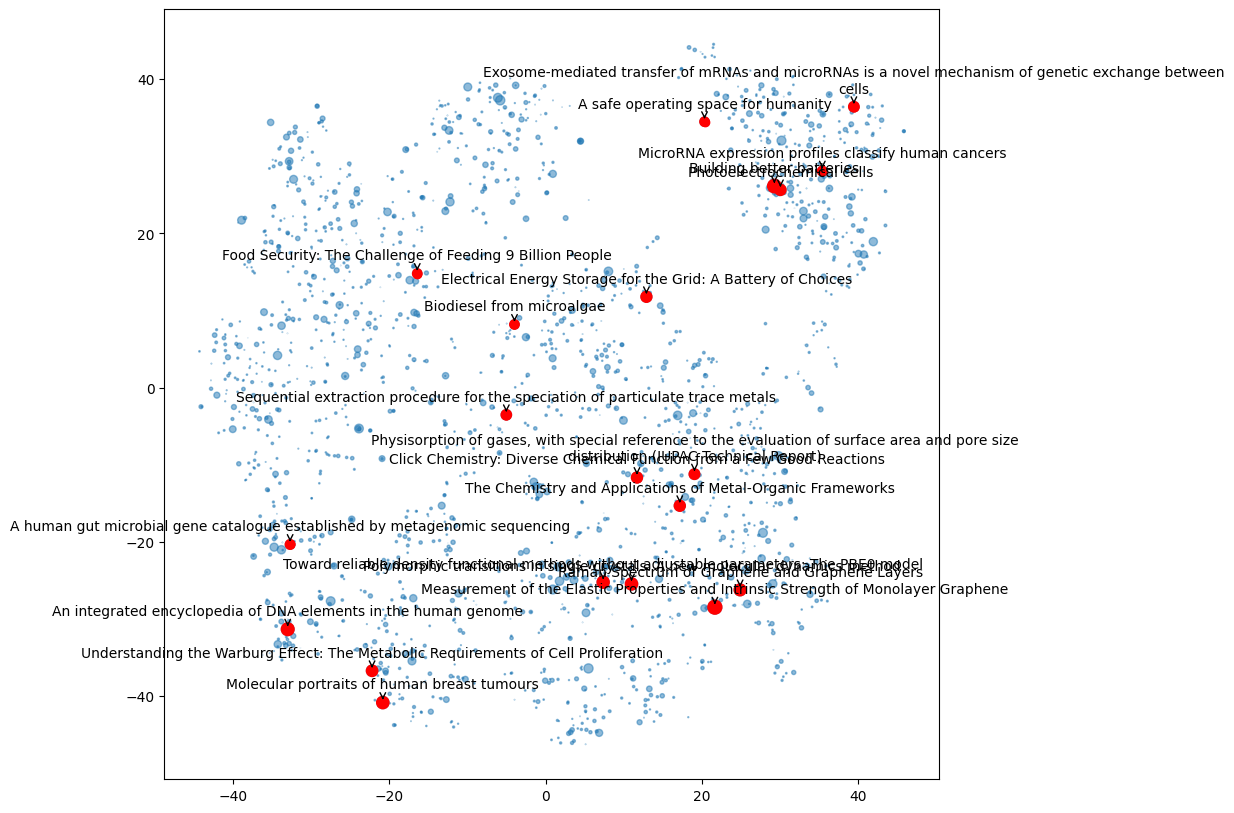

In [33]:
# Add the 2D t-SNE coordinates to the DataFrame and normalize citationCount for node sizes
df['x'] = embeddings_2d[:, 0]
df['y'] = embeddings_2d[:, 1]
df['citationCount_normalized'] = (df['citationCount'] - df['citationCount'].min()) / (df['citationCount'].max() - df['citationCount'].min())
df['citationCount_normalized'] = df['citationCount_normalized'] * 100  # Scale to a suitable range for scatter plot node sizes

# Sort the DataFrame based on citationCount and select the top 20
df_top20 = df.nlargest(20, 'citationCount')

# Create a scatter plot of all the points with node sizes based on normalized citationCount
plt.figure(figsize=(10, 10))
plt.scatter(df['x'], df['y'], s=df['citationCount_normalized'], alpha=0.5, label='All papers')

# Highlight the top 20 papers in the plot with node sizes based on normalized citationCount
plt.scatter(df_top20['x'], df_top20['y'], s=df_top20['citationCount_normalized'], color='red', label='Top 20 papers')

# Prepare to add titles of the top 20 papers to the plot with text wrapping
texts = []
for i, row in df_top20.iterrows():
    title_wrapped = textwrap.fill(row['title'], width=100)  # Wrap text after 20 characters
    plt.scatter(row['x'], row['y'], color='red')  # This will ensure the dot is above the line
    texts.append(plt.annotate(title_wrapped, (row['x'], row['y']), textcoords="offset points", xytext=(0,10), ha='center', arrowprops=dict(arrowstyle="->")))

In [35]:
# Exporting dataframe with T-SNE coordinates
df
df.to_json('t-sne/output_2000.json', orient='records')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


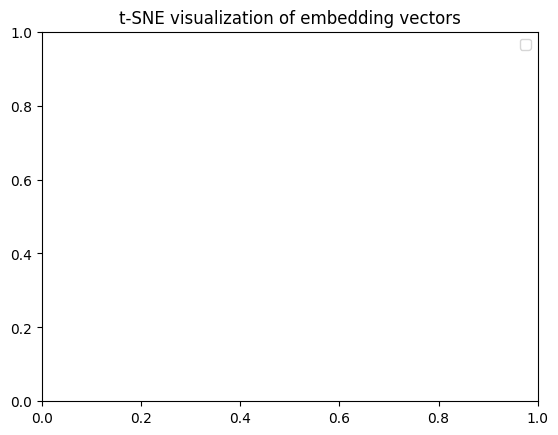

In [ ]:
# # Use adjust_text to automatically adjust the positions of the text labels
# adjust_text(texts)

# plt.title('t-SNE visualization of embedding vectors')
# plt.legend()
# plt.show()

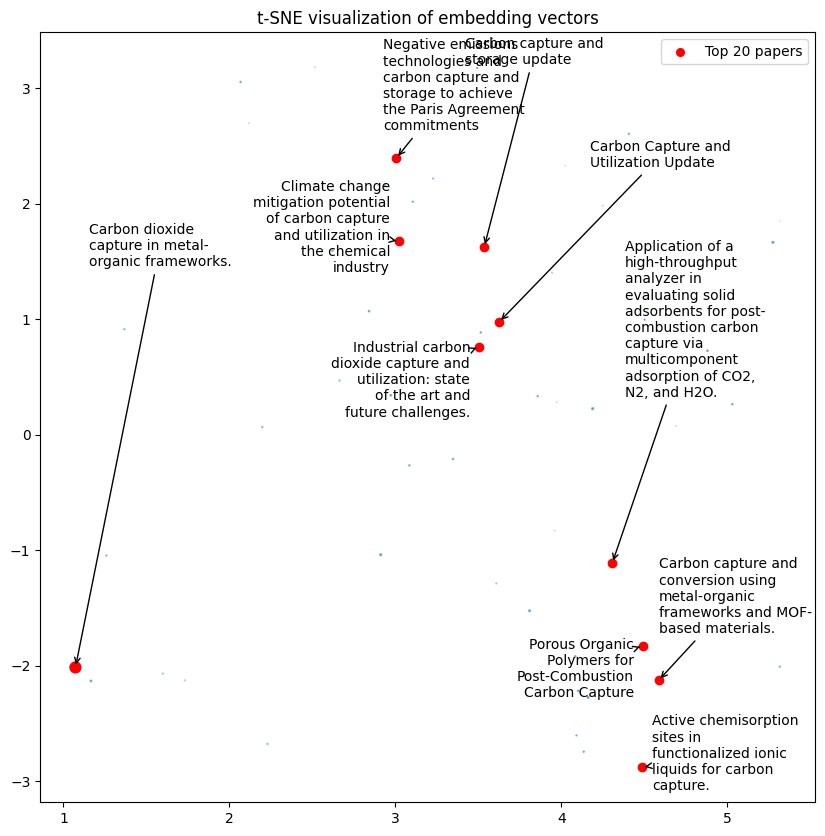

In [ ]:
# # Working implementation of t-SNE?

# # Add the 2D t-SNE coordinates to the DataFrame and normalize citationCount for node sizes
# df['x'] = embeddings_2d[:, 0]
# df['y'] = embeddings_2d[:, 1]
# df['citationCount_normalized'] = (df['citationCount'] - df['citationCount'].min()) / (df['citationCount'].max() - df['citationCount'].min())
# df['citationCount_normalized'] = df['citationCount_normalized'] * len(df)  # Scale to a suitable range for scatter plot node sizes

# # Sort the DataFrame based on citationCount and select the top 20
# df_top20 = df.nlargest(10, 'citationCount')

# # Create a scatter plot of all the points with node sizes based on normalized citationCount
# plt.figure(figsize=(10, 10))
# plt.scatter(df['x'], df['y'], s=df['citationCount_normalized'], alpha=0.5, label='All papers')

# # Highlight the top 20 papers in the plot with node sizes based on normalized citationCount
# top20_scatter = plt.scatter(df_top20['x'], df_top20['y'], s=df_top20['citationCount_normalized'], color='red')

# # Prepare to add titles of the top 20 papers to the plot with text wrapping
# texts = []
# for i, row in df_top20.iterrows():
#     title_wrapped = textwrap.fill(row['title'], width=20)  # Wrap text after 20 characters
#     plt.scatter(row['x'], row['y'], color='red')  # This will ensure the dot is above the line
#     texts.append(plt.annotate(title_wrapped, (row['x'], row['y']), textcoords="offset points", xytext=(0,10), ha='center', arrowprops=dict(arrowstyle="->")))

# # Use adjust_text to automatically adjust the positions of the text labels
# adjust_text(texts)

# plt.title('t-SNE visualization of embedding vectors')
# plt.legend(handles=[top20_scatter], labels=['Top 20 papers'])
# plt.show()

In [ ]:
# # attempting hierarchical clustering with LDA
# import pandas as pd
# from gensim.corpora import Dictionary
# from gensim.models import LdaModel
# from gensim.utils import simple_preprocess
# from sklearn.cluster import AgglomerativeClustering
# from sklearn.manifold import TSNE
# import matplotlib.pyplot as plt
# from nltk.corpus import stopwords
# from nltk.tokenize import word_tokenize

# # Download the set of stop words the first time
# import nltk
# nltk.download('stopwords')

# # Load the set of English stop words
# stop_words = set(stopwords.words('english'))

# # Assume that 'documents' is your list of documents. 
# # Each document is a string of words.

# # Preprocess your documents
# documents = df['abstract'].apply(simple_preprocess)

# # Tokenize the documents into words, convert to lower case, 
# # and remove stop words
# filtered_documents = []
# for doc in documents:
#     word_tokens = doc
#     filtered_document = [word for word in word_tokens if word not in stop_words]
#     filtered_documents.append(filtered_document)

# # Create a gensim dictionary from the documents
# dictionary = Dictionary(filtered_documents)

# # Create a corpus for LDA
# corpus = [dictionary.doc2bow(doc) for doc in documents]

# # Fit an LDA model
# lda = LdaModel(corpus, num_topics=20, id2word=dictionary, alpha='auto', eta='auto')

# # Print the top words for each topic
# for i in range(10):
#     print(f"Topic {i+1}:")
#     print([dictionary[word_id] for word_id, prob in lda.get_topic_terms(i, topn=10)])

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\1kevi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Topic 1:
['co', 'capture', 'carbon', 'mof', 'capacity', 'gas', 'adsorption', 'organic', 'metal', 'lca']
Topic 2:
['co', 'capture', 'ccs', 'carbon', 'storage', 'current', 'development', 'technologies', 'potential', 'materials']
Topic 3:
['co', 'carbon', 'capture', 'ccs', 'emissions', 'beccs', 'storage', 'gas', 'climate', 'mof']
Topic 4:
['co', 'capture', 'carbon', 'storage', 'energy', 'system', 'ccs', 'technologies', 'production', 'biomass']
Topic 5:
['co', 'carbon', 'capture', 'ccs', 'gas', 'potential', 'based', 'storage', 'emissions', 'cost']
Topic 6:
['capture', 'co', 'carbon', 'cost', 'ionic', 'liquids', 'containing', 'site', 'chemical', 'global']
Topic 7:
['co', 'carbon', 'capture', 'screening', 'new', 'climate', 'ccs', 'performance', 'materials', 'review']
Topic 8:
['carbon', 'co', 'biomass', 'capture', 'low', 'lca', 'capacity', 'emissions', 'technologies', 'high']
Topic 9:
['co', 'carbon', 'capture', 'gas', 'adsorption', 'corrosion', 'chemical', 'stability', 'emissions', 'based']

In [ ]:
# # Get the topic-document distribution from the LDA model
# topic_dist = [lda.get_document_topics(bow, minimum_probability=0) for bow in corpus]

# # Convert the topic distributions to a 2D array
# topic_dist_array = np.zeros((len(corpus), lda.num_topics))
# for i in range(len(corpus)):
#     for topic, prob in topic_dist[i]:  # topic_dist[i] is a list of tuples
#         topic_dist_array[i, topic] = prob  # topic is an integer (the topic ID)

# # Perform hierarchical clustering on the topic-document distribution
# cluster = AgglomerativeClustering(n_clusters=5)
# cluster_labels = cluster.fit_predict(topic_dist_array)

In [ ]:
# print(topic_dist)

[[(0, 0.079126924), (1, 0.00018889569), (2, 0.00018889569), (3, 0.00018889569), (4, 0.00018889569), (5, 0.00018889569), (6, 0.00018889569), (7, 0.00018889569), (8, 0.00018889569), (9, 0.00018889569), (10, 0.00018889569), (11, 0.00018889569), (12, 0.00018889569), (13, 0.9174729), (14, 0.00018889569), (15, 0.00018889569), (16, 0.00018889569), (17, 0.00018889569), (18, 0.00018889569), (19, 0.00018889569)], [(0, 0.00029949818), (1, 0.99430954), (2, 0.00029949818), (3, 0.00029949818), (4, 0.00029949818), (5, 0.00029949818), (6, 0.00029949818), (7, 0.00029949818), (8, 0.00029949818), (9, 0.00029949818), (10, 0.00029949818), (11, 0.00029949818), (12, 0.00029949818), (13, 0.00029949818), (14, 0.00029949818), (15, 0.00029949818), (16, 0.00029949818), (17, 0.00029949818), (18, 0.00029949818), (19, 0.00029949818)], [(0, 0.9965445), (1, 0.00018186746), (2, 0.00018186746), (3, 0.00018186746), (4, 0.00018186746), (5, 0.00018186746), (6, 0.00018186746), (7, 0.00018186746), (8, 0.00018186746), (9, 0.0

In [ ]:
# # Use t-SNE for visualization
# tsne = TSNE(n_components=2)
# embeddings_2d = tsne.fit_transform(topic_dist)

# # Create a scatter plot of the embeddings, colored by cluster label
# plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=cluster_labels)
# plt.show()

AttributeError: 'list' object has no attribute 'shape'

## Using LLMs for topic-based clustering

In [80]:
import pandas as pd
import json

# load the data from your JSON file
with open(r'C:\Users\1kevi\Desktop\projects\Research\autoscious-carbon-capture\knowledge_base\t-sne\output_100_tsne.json', 'r') as f:
    data = json.load(f)

# convert the data into a pandas DataFrame
df = pd.DataFrame(data)

# print out the DataFrame to verify
print(df.head())

                                    paperId  \
0  17a3eb5c5fe7d6d90cde7098b5fceead18ae2d33   
1  f15a2d21309f429fbec688b8aee5c7bdb66b8f40   
2  a4830bc41a88ee369f08c0556360c12cf887f564   
3  ecacc2f192e4b881ca95749821b9d8595a81477b   
4  9a722f9ec3bca95b5f86b501706d040dc968472d   

                                                 url  \
0  https://www.semanticscholar.org/paper/17a3eb5c...   
1  https://www.semanticscholar.org/paper/f15a2d21...   
2  https://www.semanticscholar.org/paper/a4830bc4...   
3  https://www.semanticscholar.org/paper/ecacc2f1...   
4  https://www.semanticscholar.org/paper/9a722f9e...   

                                               title  \
0  Carbon capture and storage at the end of a los...   
1  Renewable-integrated flexible carbon capture: ...   
2  Recent advances in carbon capture storage and ...   
3                         Atmospheric Carbon Capture   
4  Carbon mineralization pathways for carbon capt...   

                                           

In [1]:
# Using GPT3.5 to generate topics

# imports
%load_ext dotenv
%dotenv
import os
# openai_api_key = os.getenv('OPENAI_API_KEY')
openai_api_key = os.getenv('OPENAI_GPT4_API_KEY')
import openai

# models
EMBEDDING_MODEL = "text-embedding-ada-002"
GPT_MODEL = "gpt-3.5-turbo"
# GPT_MODEL = "gpt-4"

# for bulk openai message, no stream
def chat_openai(prompt="Tell me to ask you a prompt", chat_history=[]):
    # define message conversation for model
    if chat_history:
        messages = chat_history
    else:
        messages = [
            {"role": "system", "content": "You are ChatGPT, a large language model trained by OpenAI. Answer as concisely as possible."},
        ]
    messages.append({"role": "user", "content": prompt})

    # create the chat completion
    print("Prompt: ", prompt)
    completion = openai.ChatCompletion.create(
        model=GPT_MODEL,
        messages=messages,
        temperature=0
    )
    print("Completion info: ", completion)
    text_answer = completion["choices"][0]["message"]["content"]

    # updated conversation history
    messages.append({"role": "assistant", "content": text_answer})

    return text_answer, messages

#### 1. Seeding – Ask GPT4 to be a domain expert and use “expert knowledge” to seed an initial taxonomy definition of main classes, subclasses, and divisions

In [55]:
seed_initial_taxonomy_prompt = '''
You are an expert in the field of carbon capture. You are asked to create a taxonomy of all carbon capture research areas. Do your best to be as mutually exclusive, completely exhaustive (MECE) as possible. Be sure to also include a "General" category for information like literature reviews and updates, a "Miscellaneous" category for concepts that have yet to be covered by an appropriate category and non-carbon capture related concepts.
'''

In [56]:
res = chat_openai(seed_initial_taxonomy_prompt)
res[0]

Completion info:  {
  "choices": [
    {
      "finish_reason": "stop",
      "index": 0,
      "message": {
        "content": "Here is a taxonomy of carbon capture research areas, organized in a mutually exclusive, completely exhaustive (MECE) manner:\n\n1. General:\n   - Literature reviews\n   - Updates and news\n\n2. Carbon Capture Technologies:\n   - Post-combustion capture\n   - Pre-combustion capture\n   - Oxy-fuel combustion capture\n   - Direct air capture\n   - Biological capture\n   - Mineralization and carbonation\n\n3. Carbon Capture Materials:\n   - Solvents and sorbents\n   - Membranes\n   - Adsorbents\n   - Catalysts\n   - Solid sorbents\n   - Ionic liquids\n\n4. Carbon Capture Processes:\n   - Absorption\n   - Adsorption\n   - Membrane separation\n   - Cryogenic separation\n   - Chemical looping\n   - Electrochemical capture\n\n5. Carbon Capture Integration:\n   - Power plants\n   - Industrial processes\n   - Transportation\n   - Buildings and infrastructure\n   - Carb

'Here is a taxonomy of carbon capture research areas, organized in a mutually exclusive, completely exhaustive (MECE) manner:\n\n1. General:\n   - Literature reviews\n   - Updates and news\n\n2. Carbon Capture Technologies:\n   - Post-combustion capture\n   - Pre-combustion capture\n   - Oxy-fuel combustion capture\n   - Direct air capture\n   - Biological capture\n   - Mineralization and carbonation\n\n3. Carbon Capture Materials:\n   - Solvents and sorbents\n   - Membranes\n   - Adsorbents\n   - Catalysts\n   - Solid sorbents\n   - Ionic liquids\n\n4. Carbon Capture Processes:\n   - Absorption\n   - Adsorption\n   - Membrane separation\n   - Cryogenic separation\n   - Chemical looping\n   - Electrochemical capture\n\n5. Carbon Capture Integration:\n   - Power plants\n   - Industrial processes\n   - Transportation\n   - Buildings and infrastructure\n   - Carbon capture and utilization/storage (CCU/CCS)\n\n6. Carbon Capture Storage:\n   - Geological storage\n   - Ocean storage\n   - Mi

In [57]:
initial_taxonomy = res[0]
print(initial_taxonomy)

Here is a taxonomy of carbon capture research areas, organized in a mutually exclusive, completely exhaustive (MECE) manner:

1. General:
   - Literature reviews
   - Updates and news

2. Carbon Capture Technologies:
   - Post-combustion capture
   - Pre-combustion capture
   - Oxy-fuel combustion capture
   - Direct air capture
   - Biological capture
   - Mineralization and carbonation

3. Carbon Capture Materials:
   - Solvents and sorbents
   - Membranes
   - Adsorbents
   - Catalysts
   - Solid sorbents
   - Ionic liquids

4. Carbon Capture Processes:
   - Absorption
   - Adsorption
   - Membrane separation
   - Cryogenic separation
   - Chemical looping
   - Electrochemical capture

5. Carbon Capture Integration:
   - Power plants
   - Industrial processes
   - Transportation
   - Buildings and infrastructure
   - Carbon capture and utilization/storage (CCU/CCS)

6. Carbon Capture Storage:
   - Geological storage
   - Ocean storage
   - Mineral storage
   - Enhanced oil recovery 

In [140]:
jsonify_taxonomy_prompt = f'''
{initial_taxonomy}

Put the above hierarchy of categories and sub-categories into a JSON format of 1. unique id (integer), 2. name of the category, 3. layer in the hierarchy (integer), and 4. content (a list of subcategories) 

The output should be of this format: [
    {{
        "cluster_id": 0,
        "name": "General"
        "layer": 0,
        "content": [...],
    }}
]
'''

In [ ]:
# res = chat_openai(jsonify_taxonomy_prompt)
# res[0]

In [ ]:
# print(res[0])

In [134]:
# # Convert the string to Python objects
# initial_taxonomy_json = json.loads(res[0])

# # To write to a JSON file
# with open('clusters/initial_taxonomy.json', 'w') as f:
#     json.dump(initial_taxonomy_json, f, indent=2)

In [135]:
# # To read the data back into Python
# with open('clusters/initial_taxonomy.json', 'r') as f:
#     data = json.load(f)

# print(data)

[{'cluster_id': 1, 'name': 'General', 'layer': 0, 'content': [{'cluster_id': 2, 'name': 'Literature reviews', 'layer': 1, 'content': []}, {'cluster_id': 3, 'name': 'Updates and news', 'layer': 1, 'content': []}]}, {'cluster_id': 4, 'name': 'Carbon Capture Technologies', 'layer': 0, 'content': [{'cluster_id': 5, 'name': 'Post-combustion capture', 'layer': 1, 'content': []}, {'cluster_id': 6, 'name': 'Pre-combustion capture', 'layer': 1, 'content': []}, {'cluster_id': 7, 'name': 'Oxy-fuel combustion capture', 'layer': 1, 'content': []}, {'cluster_id': 8, 'name': 'Direct air capture', 'layer': 1, 'content': []}, {'cluster_id': 9, 'name': 'Industrial process capture', 'layer': 1, 'content': []}, {'cluster_id': 10, 'name': 'Biological capture', 'layer': 1, 'content': []}]}, {'cluster_id': 11, 'name': 'Carbon Capture Materials', 'layer': 0, 'content': [{'cluster_id': 12, 'name': 'Solvents', 'layer': 1, 'content': []}, {'cluster_id': 13, 'name': 'Sorbents', 'layer': 1, 'content': []}, {'clust

#### 2. Initial categorization – Use GPT3.5 to look at 1) the seeded taxonomy and 2) paper titles and abstracts, 3) categorize the paper title and abstract and adapt the seeded taxonomy as necessary.

In [58]:
initial_taxonomy

'Here is a taxonomy of carbon capture research areas, organized in a mutually exclusive, completely exhaustive (MECE) manner:\n\n1. General:\n   - Literature reviews\n   - Updates and news\n\n2. Carbon Capture Technologies:\n   - Post-combustion capture\n   - Pre-combustion capture\n   - Oxy-fuel combustion capture\n   - Direct air capture\n   - Biological capture\n   - Mineralization and carbonation\n\n3. Carbon Capture Materials:\n   - Solvents and sorbents\n   - Membranes\n   - Adsorbents\n   - Catalysts\n   - Solid sorbents\n   - Ionic liquids\n\n4. Carbon Capture Processes:\n   - Absorption\n   - Adsorption\n   - Membrane separation\n   - Cryogenic separation\n   - Chemical looping\n   - Electrochemical capture\n\n5. Carbon Capture Integration:\n   - Power plants\n   - Industrial processes\n   - Transportation\n   - Buildings and infrastructure\n   - Carbon capture and utilization/storage (CCU/CCS)\n\n6. Carbon Capture Storage:\n   - Geological storage\n   - Ocean storage\n   - Mi

In [59]:
index_taxonomy_prompt = f'''
{initial_taxonomy}

Put the above hierarchy of categories and sub-categories into a multilevel number format of 1. id and 2. name of the category.

The output should be of this format: 
1. Category
1.1 Sub-category
1.1.1 Sub-sub-category
etc.
...

'''

In [60]:
res = chat_openai(index_taxonomy_prompt)
res[0]

Completion info:  {
  "choices": [
    {
      "finish_reason": "stop",
      "index": 0,
      "message": {
        "content": "1. General\n1.1 Literature reviews\n1.2 Updates and news\n2. Carbon Capture Technologies\n2.1 Post-combustion capture\n2.2 Pre-combustion capture\n2.3 Oxy-fuel combustion capture\n2.4 Direct air capture\n2.5 Biological capture\n2.6 Mineralization and carbonation\n3. Carbon Capture Materials\n3.1 Solvents and sorbents\n3.2 Membranes\n3.3 Adsorbents\n3.4 Catalysts\n3.5 Solid sorbents\n3.6 Ionic liquids\n4. Carbon Capture Processes\n4.1 Absorption\n4.2 Adsorption\n4.3 Membrane separation\n4.4 Cryogenic separation\n4.5 Chemical looping\n4.6 Electrochemical capture\n5. Carbon Capture Integration\n5.1 Power plants\n5.2 Industrial processes\n5.3 Transportation\n5.4 Buildings and infrastructure\n5.5 Carbon capture and utilization/storage (CCU/CCS)\n6. Carbon Capture Storage\n6.1 Geological storage\n6.2 Ocean storage\n6.3 Mineral storage\n6.4 Enhanced oil recovery (EO

'1. General\n1.1 Literature reviews\n1.2 Updates and news\n2. Carbon Capture Technologies\n2.1 Post-combustion capture\n2.2 Pre-combustion capture\n2.3 Oxy-fuel combustion capture\n2.4 Direct air capture\n2.5 Biological capture\n2.6 Mineralization and carbonation\n3. Carbon Capture Materials\n3.1 Solvents and sorbents\n3.2 Membranes\n3.3 Adsorbents\n3.4 Catalysts\n3.5 Solid sorbents\n3.6 Ionic liquids\n4. Carbon Capture Processes\n4.1 Absorption\n4.2 Adsorption\n4.3 Membrane separation\n4.4 Cryogenic separation\n4.5 Chemical looping\n4.6 Electrochemical capture\n5. Carbon Capture Integration\n5.1 Power plants\n5.2 Industrial processes\n5.3 Transportation\n5.4 Buildings and infrastructure\n5.5 Carbon capture and utilization/storage (CCU/CCS)\n6. Carbon Capture Storage\n6.1 Geological storage\n6.2 Ocean storage\n6.3 Mineral storage\n6.4 Enhanced oil recovery (EOR)\n6.5 Carbon capture and utilization/storage (CCU/CCS)\n7. Carbon Capture Policy and Economics\n7.1 Policy frameworks and regu

In [61]:
numbered_taxonomy = res[0]

In [82]:
df

,paperId,url,title,abstract,year,citationCount,isOpenAccess,fieldsOfStudy,s2FieldsOfStudy,embedding,tldr,citations,references,x,y,citationCount_normalized,text
0,17a3eb5c5fe7d6d90cde7098b5fceead18ae2d33,https://www.semanticscholar.org/paper/17a3eb5c...,Carbon capture and storage at the end of a los...,None,2021,51,True,None,"[{'category': 'Engineering', 'source': 's2-fos...","{'model': 'specter@v0.1.1', 'vector': [-0.3693...",None,[{'paperId': '0fbc075056e6f013959529ebd322e9c7...,[{'paperId': '979676198e622a6c39daefcb08f88c94...,3.260468,-8.768986,0.993184,Carbon capture and storage at the end of a los...
1,f15a2d21309f429fbec688b8aee5c7bdb66b8f40,https://www.semanticscholar.org/paper/f15a2d21...,Renewable-integrated flexible carbon capture: ...,"To decarbonize electricity grids, CO2 capture ...",2021,28,False,[Environmental Science],"[{'category': 'Environmental Science', 'source...","{'model': 'specter@v0.1.1', 'vector': [-1.3025...",None,[{'paperId': '0fbc075056e6f013959529ebd322e9c7...,[{'paperId': 'ebceec9a3f0187faf186697ff05450c5...,3.993077,-7.075522,0.545278,Renewable-integrated flexible carbon capture: ...
2,a4830bc41a88ee369f08c0556360c12cf887f564,https://www.semanticscholar.org/paper/a4830bc4...,Recent advances in carbon capture storage and ...,None,2020,206,True,[Materials Science],"[{'category': 'Materials Science', 'source': '...","{'model': 'specter@v0.1.1', 'vector': [4.65861...",None,[{'paperId': '41fb6867c18f3e3a8ca70e8ce9388c51...,[{'paperId': '965050bb8475801dfcfd49509a529aa1...,1.354568,-11.164637,4.011685,Recent advances in carbon capture storage and ...
3,ecacc2f192e4b881ca95749821b9d8595a81477b,https://www.semanticscholar.org/paper/ecacc2f1...,Atmospheric Carbon Capture,None,2022,0,False,None,"[{'category': 'Environmental Science', 'source...","{'model': 'specter@v0.1.1', 'vector': [2.25967...",None,[],[],2.523121,-6.680912,0.000000,Atmospheric Carbon Capture
4,9a722f9ec3bca95b5f86b501706d040dc968472d,https://www.semanticscholar.org/paper/9a722f9e...,Carbon mineralization pathways for carbon capt...,None,2021,28,True,[Medicine],"[{'category': 'Medicine', 'source': 'external'...","{'model': 'specter@v0.1.1', 'vector': [3.95449...",None,[{'paperId': 'cdf54c05ca1e314605992c5639c28a45...,[{'paperId': '9c96e28b7a2e5a312b203df19a8a515d...,-4.000884,-4.188164,0.545278,Carbon mineralization pathways for carbon capt...
5,5b190c555003e154bb9038844899014425236273,https://www.semanticscholar.org/paper/5b190c55...,Carbon capture and conversion using metal-orga...,Rapidly increasing atmospheric CO2 concentrati...,2019,802,False,"[Materials Science, Medicine]","[{'category': 'Materials Science', 'source': '...","{'model': 'specter@v0.1.1', 'vector': [1.39446...","{'model': 'tldr@v2.0.0', 'text': 'This review ...",[{'paperId': '9945477c16dc599782d591b083667130...,[{'paperId': 'a367444fd74633e0b2b1701ed8e6b2c6...,1.270259,1.645935,15.618306,Carbon capture and conversion using metal-orga...
6,e24d6d882c78389a9c356b87ac46e065087549cf,https://www.semanticscholar.org/paper/e24d6d88...,Climate change mitigation potential of carbon ...,Significance Carbon dioxide (CO2) drives clima...,2019,286,True,"[Medicine, Environmental Science]","[{'category': 'Medicine', 'source': 'external'...","{'model': 'specter@v0.1.1', 'vector': [2.02770...","{'model': 'tldr@v2.0.0', 'text': 'This study s...",[{'paperId': '2733db5f887f33e240477b301c648e82...,[{'paperId': '206fc8a956283c0bd96afdbeaf3d693f...,2.133464,-6.738343,5.569620,Climate change mitigation potential of carbon ...
7,c5d58c42f6af877a3b99a98114c1c633674928af,https://www.semanticscholar.org/paper/c5d58c42...,The climate change mitigation potential of bio...,None,2020,95,True,[Environmental Science],"[{'category': 'Environmental Science', 'source...","{'model': 'specter@v0.1.1', 'vector': [-0.3296...",None,[{'paperId': 'eb024cdd3e651300a6995dc5558f8f85...,[{'paperId': '979676198e622a6c39daefcb08f88c94...,2.335546,-8.235400,1.850049,The climate change mitigation potential of bio...
8

In [81]:
# Create a new text column
df['text'] = df.apply(lambda row: row['title'] if pd.isna(row['abstract']) else row['title'] + '. ' + row['abstract'], axis=1)
df.head()


,paperId,url,title,abstract,year,citationCount,isOpenAccess,fieldsOfStudy,s2FieldsOfStudy,embedding,tldr,citations,references,x,y,citationCount_normalized,text
0,17a3eb5c5fe7d6d90cde7098b5fceead18ae2d33,https://www.semanticscholar.org/paper/17a3eb5c...,Carbon capture and storage at the end of a los...,None,2021,51,True,None,"[{'category': 'Engineering', 'source': 's2-fos...","{'model': 'specter@v0.1.1', 'vector': [-0.3693...",None,[{'paperId': '0fbc075056e6f013959529ebd322e9c7...,[{'paperId': '979676198e622a6c39daefcb08f88c94...,3.260468,-8.768986,0.993184,Carbon capture and storage at the end of a los...
1,f15a2d21309f429fbec688b8aee5c7bdb66b8f40,https://www.semanticscholar.org/paper/f15a2d21...,Renewable-integrated flexible carbon capture: ...,"To decarbonize electricity grids, CO2 capture ...",2021,28,False,[Environmental Science],"[{'category': 'Environmental Science', 'source...","{'model': 'specter@v0.1.1', 'vector': [-1.3025...",None,[{'paperId': '0fbc075056e6f013959529ebd322e9c7...,[{'paperId': 'ebceec9a3f0187faf186697ff05450c5...,3.993077,-7.075522,0.545278,Renewable-integrated flexible carbon capture: ...
2,a4830bc41a88ee369f08c0556360c12cf887f564,https://www.semanticscholar.org/paper/a4830bc4...,Recent advances in carbon capture storage and ...,None,2020,206,True,[Materials Science],"[{'category': 'Materials Science', 'source': '...","{'model': 'specter@v0.1.1', 'vector': [4.65861...",None,[{'paperId': '41fb6867c18f3e3a8ca70e8ce9388c51...,[{'paperId': '965050bb8475801dfcfd49509a529aa1...,1.354568,-11.164637,4.011685,Recent advances in carbon capture storage and ...
3,ecacc2f192e4b881ca95749821b9d8595a81477b,https://www.semanticscholar.org/paper/ecacc2f1...,Atmospheric Carbon Capture,None,2022,0,False,None,"[{'category': 'Environmental Science', 'source...","{'model': 'specter@v0.1.1', 'vector': [2.25967...",None,[],[],2.523121,-6.680912,0.000000,Atmospheric Carbon Capture
4,9a722f9ec3bca95b5f86b501706d040dc968472d,https://www.semanticscholar.org/paper/9a722f9e...,Carbon mineralization pathways for carbon capt...,None,2021,28,True,[Medicine],"[{'category': 'Medicine', 'source': 'external'...","{'model': 'specter@v0.1.1', 'vector': [3.95449...",None,[{'paperId': 'cdf54c05ca1e314605992c5639c28a45...,[{'paperId': '9c96e28b7a2e5a312b203df19a8a515d...,-4.000884,-4.188164,0.545278,Carbon mineralization pathways for carbon capt...


In [3]:
def retrieve_update_taxonomy_and_classify_paper_prompt(taxonomy, papers):
    update_taxonomy_and_classify_paper_prompt = f'''
    Task:
    You are an expert in carbon capture. The task is to update a taxonomy of all carbon capture research and correctly classify papers into the updated taxonomy. Be as accurate as possible. Accurately classify each paper below into at most 2 accurate leaf categories in the updated taxonomy. Add new categories or extend the multi-level taxonomy into more levels if appropriate. 

    Papers (id : text): 
    {papers}

    Taxonomy (id : name): 
    {taxonomy}

    The output should be in the format of: 
    1. "UPDATED TAXONOMY: " -- an updated multilevel taxonomy with any new categories or level extensions added.
    2. "PAPER CLASSIFICATION: [{{paper id : [category id 1, etc.]}}, etc.]" -- each paper id with a list of leafcategory ids. Rank by most to least accurate leaf category ids.
    '''

    return update_taxonomy_and_classify_paper_prompt

In [ ]:
# Iterate through df and get updated taxonomy and classify each paper under categories


In [ ]:
# print("prompt: ", retrieve_update_taxonomy_and_classify_paper_prompt)
# res = chat_openai(retrieve_update_taxonomy_and_classify_paper_prompt)
# print(res[0])

In [4]:
# Putting everything together to iterate through all papers, update and save taxonomy, and add category ids to each paper
import pandas as pd
import json
import re
import ast  # The Abstract Syntax Trees module

def extract_taxonomy_and_classification(chat_output):
    taxonomy_start = chat_output.find('UPDATED TAXONOMY:') + len('UPDATED TAXONOMY:')
    taxonomy_end = chat_output.find('PAPER CLASSIFICATION:')
    updated_taxonomy = chat_output[taxonomy_start:taxonomy_end].strip()
    
    # Extract paper classifications using regular expressions
    classification_str = chat_output[taxonomy_end+len('PAPER CLASSIFICATION:'):].strip()
    # Safely evaluate an expression node or a string containing a Python literal or container display
    paper_classification = ast.literal_eval(classification_str)
    
    # Convert list of dicts into a dict
    paper_classification_dict = {list(item.keys())[0]: list(item.values())[0] for item in paper_classification}

    return updated_taxonomy, paper_classification_dict


In [90]:
updated_taxonomy, paper_classification_dict = extract_taxonomy_and_classification(res[0])
print(updated_taxonomy)
print(paper_classification_dict)

1. General
1.1 Literature reviews
1.2 Updates and news
2. Carbon Capture Technologies
2.1 Post-combustion capture
2.2 Pre-combustion capture
2.3 Oxy-fuel combustion capture
2.4 Direct air capture
2.5 Biological capture
2.6 Mineralization and carbonation
2.7 Metal organic frameworks
3. Carbon Capture Materials
3.1 Solvents and sorbents
3.2 Membranes
3.3 Adsorbents
3.4 Catalysts
3.5 Solid sorbents
3.6 Ionic liquids
4. Carbon Capture Processes
4.1 Absorption
4.2 Adsorption
4.3 Membrane separation
4.4 Cryogenic separation
4.5 Chemical looping
4.6 Electrochemical capture
5. Carbon Capture Integration
5.1 Power plants
5.2 Industrial processes
5.3 Transportation
5.4 Buildings and infrastructure
5.5 Carbon capture and utilization/storage (CCU/CCS)
6. Carbon Capture Storage
6.1 Geological storage
6.2 Ocean storage
6.3 Mineral storage
6.4 Enhanced oil recovery (EOR)
6.5 Carbon capture and utilization/storage (CCU/CCS)
7. Carbon Capture Policy and Economics
7.1 Policy frameworks and regulations
7

In [83]:
df['classification_ids'] = pd.Series(dtype='object')
df.head()

,paperId,url,title,abstract,year,citationCount,isOpenAccess,fieldsOfStudy,s2FieldsOfStudy,embedding,tldr,citations,references,x,y,citationCount_normalized,text,classification_ids
0,17a3eb5c5fe7d6d90cde7098b5fceead18ae2d33,https://www.semanticscholar.org/paper/17a3eb5c...,Carbon capture and storage at the end of a los...,None,2021,51,True,None,"[{'category': 'Engineering', 'source': 's2-fos...","{'model': 'specter@v0.1.1', 'vector': [-0.3693...",None,[{'paperId': '0fbc075056e6f013959529ebd322e9c7...,[{'paperId': '979676198e622a6c39daefcb08f88c94...,3.260468,-8.768986,0.993184,Carbon capture and storage at the end of a los...,NaN
1,f15a2d21309f429fbec688b8aee5c7bdb66b8f40,https://www.semanticscholar.org/paper/f15a2d21...,Renewable-integrated flexible carbon capture: ...,"To decarbonize electricity grids, CO2 capture ...",2021,28,False,[Environmental Science],"[{'category': 'Environmental Science', 'source...","{'model': 'specter@v0.1.1', 'vector': [-1.3025...",None,[{'paperId': '0fbc075056e6f013959529ebd322e9c7...,[{'paperId': 'ebceec9a3f0187faf186697ff05450c5...,3.993077,-7.075522,0.545278,Renewable-integrated flexible carbon capture: ...,NaN
2,a4830bc41a88ee369f08c0556360c12cf887f564,https://www.semanticscholar.org/paper/a4830bc4...,Recent advances in carbon capture storage and ...,None,2020,206,True,[Materials Science],"[{'category': 'Materials Science', 'source': '...","{'model': 'specter@v0.1.1', 'vector': [4.65861...",None,[{'paperId': '41fb6867c18f3e3a8ca70e8ce9388c51...,[{'paperId': '965050bb8475801dfcfd49509a529aa1...,1.354568,-11.164637,4.011685,Recent advances in carbon capture storage and ...,NaN
3,ecacc2f192e4b881ca95749821b9d8595a81477b,https://www.semanticscholar.org/paper/ecacc2f1...,Atmospheric Carbon Capture,None,2022,0,False,None,"[{'category': 'Environmental Science', 'source...","{'model': 'specter@v0.1.1', 'vector': [2.25967...",None,[],[],2.523121,-6.680912,0.000000,Atmospheric Carbon Capture,NaN
4,9a722f9ec3bca95b5f86b501706d040dc968472d,https://www.semanticscholar.org/paper/9a722f9e...,Carbon mineralization pathways for carbon capt...,None,2021,28,True,[Medicine],"[{'category': 'Medicine', 'source': 'external'...","{'model': 'specter@v0.1.1', 'vector': [3.95449...",None,[{'paperId': 'cdf54c05ca1e314605992c5639c28a45...,[{'paperId': '9c96e28b7a2e5a312b203df19a8a515d...,-4.000884,-4.188164,0.545278,Carbon mineralization pathways for carbon capt...,NaN


In [35]:
# read and update df and numbered_taxonomy from last checkpoint
import pandas as pd

# Read the csv file into a pandas DataFrame
df = pd.read_csv('checkpoints/papers_100_semantic_scholar.csv')

# Read the text file
with open('checkpoints/taxonomy_100_semantic_scholar.txt', 'r') as f:
    numbered_taxonomy = f.read()

df.head()
# print(updated_taxonomy)

,paperId,url,title,abstract,year,citationCount,isOpenAccess,fieldsOfStudy,s2FieldsOfStudy,embedding,tldr,citations,references,x,y,citationCount_normalized,text,classification_ids
0,17a3eb5c5fe7d6d90cde7098b5fceead18ae2d33,https://www.semanticscholar.org/paper/17a3eb5c...,Carbon capture and storage at the end of a los...,NaN,2021,51,True,NaN,"[{'category': 'Engineering', 'source': 's2-fos...","{'model': 'specter@v0.1.1', 'vector': [-0.3693...",NaN,[{'paperId': '0fbc075056e6f013959529ebd322e9c7...,[{'paperId': '979676198e622a6c39daefcb08f88c94...,3.260468,-8.768986,0.993184,Carbon capture and storage at the end of a los...,[1.2]
1,f15a2d21309f429fbec688b8aee5c7bdb66b8f40,https://www.semanticscholar.org/paper/f15a2d21...,Renewable-integrated flexible carbon capture: ...,"To decarbonize electricity grids, CO2 capture ...",2021,28,False,['Environmental Science'],"[{'category': 'Environmental Science', 'source...","{'model': 'specter@v0.1.1', 'vector': [-1.3025...",NaN,[{'paperId': '0fbc075056e6f013959529ebd322e9c7...,[{'paperId': 'ebceec9a3f0187faf186697ff05450c5...,3.993077,-7.075522,0.545278,Renewable-integrated flexible carbon capture: ...,"[5.5, 2.1]"
2,a4830bc41a88ee369f08c0556360c12cf887f564,https://www.semanticscholar.org/paper/a4830bc4...,Recent advances in carbon capture storage and ...,NaN,2020,206,True,['Materials Science'],"[{'category': 'Materials Science', 'source': '...","{'model': 'specter@v0.1.1', 'vector': [4.65861...",NaN,[{'paperId': '41fb6867c18f3e3a8ca70e8ce9388c51...,[{'paperId': '965050bb8475801dfcfd49509a529aa1...,1.354568,-11.164637,4.011685,Recent advances in carbon capture storage and ...,"[1.1, 2.6]"
3,ecacc2f192e4b881ca95749821b9d8595a81477b,https://www.semanticscholar.org/paper/ecacc2f1...,Atmospheric Carbon Capture,NaN,2022,0,False,NaN,"[{'category': 'Environmental Science', 'source...","{'model': 'specter@v0.1.1', 'vector': [2.25967...",NaN,[],[],2.523121,-6.680912,0.000000,Atmospheric Carbon Capture,[2.4]
4,9a722f9ec3bca95b5f86b501706d040dc968472d,https://www.semanticscholar.org/paper/9a722f9e...,Carbon mineralization pathways for carbon capt...,NaN,2021,28,True,['Medicine'],"[{'category': 'Medicine', 'source': 'external'...","{'model': 'specter@v0.1.1', 'vector': [3.95449...",NaN,[{'paperId': 'cdf54c05ca1e314605992c5639c28a45...,[{'paperId': '9c96e28b7a2e5a312b203df19a8a515d...,-4.000884,-4.188164,0.545278,Carbon mineralization pathways for carbon capt...,[2.6]


In [46]:
pd.set_option('display.max_rows', None)

In [59]:
def process_papers(df, numbered_taxonomy):
    batch_size = 10
    for _ in range(0, df.shape[0], batch_size):

        # only select rows that don't have classification ids yet
        subset = df.loc[df['classification_ids'].isna(), 'paperId':'text'][:batch_size]
        print("Checking rows ", subset.index.min(), " to ", subset.index.max())
        print("df", df['classification_ids'])

        # skip if subset is empty
        if subset.empty:
            print("subset was all classified!")
            continue
        
        # Create dictionary mapping index to paperId
        index_to_paperId = {i: row['paperId'] for i, (_, row) in enumerate(subset.iterrows())}
        papers = {i: row['text'] for i, (_, row) in enumerate(subset.iterrows())}
        
        prompt = retrieve_update_taxonomy_and_classify_paper_prompt(numbered_taxonomy, papers)
        res = chat_openai(prompt)  # call to OpenAI API
        
        # parse the res[0]
        updated_taxonomy, paper_classification = extract_taxonomy_and_classification(res[0])
        print("updated taxonomy: ", updated_taxonomy)
        print("paper classification: ", paper_classification)
    
        # update DataFrame using index_to_paperId
        for idx, class_ids in paper_classification.items():
            paper_id = index_to_paperId[idx]  # map index back to paperId
            df.loc[df['paperId'] == paper_id, 'classification_ids'] = df.loc[df['paperId'] == paper_id, 'classification_ids'].apply(lambda x: class_ids)
            
        # save the taxonomy and df to a txt and csv file
        with open('checkpoints/taxonomy_100_semantic_scholar_leaf.txt', 'w') as f:
            f.write(updated_taxonomy)

            
        df.to_csv('checkpoints/papers_100_semantic_scholar_leaf.csv', index=False)
        numbered_taxonomy = updated_taxonomy  # update the taxonomy for the next batch of papers

    return df, numbered_taxonomy

In [84]:
process_papers(df, numbered_taxonomy)

Checking rows  0  to  9
df 0     NaN
1     NaN
2     NaN
3     NaN
4     NaN
5     NaN
6     NaN
7     NaN
8     NaN
9     NaN
10    NaN
11    NaN
12    NaN
13    NaN
14    NaN
15    NaN
16    NaN
17    NaN
18    NaN
19    NaN
20    NaN
21    NaN
22    NaN
23    NaN
24    NaN
25    NaN
26    NaN
27    NaN
28    NaN
29    NaN
30    NaN
31    NaN
32    NaN
33    NaN
34    NaN
35    NaN
36    NaN
37    NaN
38    NaN
39    NaN
40    NaN
41    NaN
42    NaN
43    NaN
44    NaN
45    NaN
46    NaN
47    NaN
48    NaN
49    NaN
50    NaN
51    NaN
52    NaN
53    NaN
54    NaN
55    NaN
56    NaN
57    NaN
58    NaN
59    NaN
60    NaN
61    NaN
62    NaN
63    NaN
64    NaN
65    NaN
66    NaN
67    NaN
68    NaN
69    NaN
70    NaN
71    NaN
72    NaN
73    NaN
74    NaN
75    NaN
76    NaN
77    NaN
78    NaN
79    NaN
80    NaN
81    NaN
82    NaN
83    NaN
84    NaN
85    NaN
86    NaN
87    NaN
88    NaN
89    NaN
90    NaN
91    NaN
92    NaN
93    NaN
94    NaN
95    NaN
96    NaN
97 

(                                     paperId  \
 0   17a3eb5c5fe7d6d90cde7098b5fceead18ae2d33   
 1   f15a2d21309f429fbec688b8aee5c7bdb66b8f40   
 2   a4830bc41a88ee369f08c0556360c12cf887f564   
 3   ecacc2f192e4b881ca95749821b9d8595a81477b   
 4   9a722f9ec3bca95b5f86b501706d040dc968472d   
 5   5b190c555003e154bb9038844899014425236273   
 6   e24d6d882c78389a9c356b87ac46e065087549cf   
 7   c5d58c42f6af877a3b99a98114c1c633674928af   
 8   9496966a27c7a9176ec0a8ff6a04781caa42b7bb   
 9   154b9fd69570539e90f51e1b19db944713d3bfdc   
 10  e3e850fb87909bd91aab7ecb8260417ccfcb383b   
 11  19b604c4e00c43cfd916603d20b2532ccb2896ea   
 12  7cb3034e94dce60304b7890b0e47786f1f1538e0   
 13  054fa9dd6cd640002c9ffcd1292ac14b9840db6b   
 14  d3b50f8169f7a2316eacd443038e916fb5bb0193   
 15  620999ecca4608a89bd69cbe97ab752ce1e62161   
 16  cfa569019717301c352aabec292a8f4d3a261553   
 17  eff38e9fd207de2256d78aa3a1a8bfba019095c5   
 18  65edec1eed534fb0b88c5d1a9f829bf00303b454   
 19  032b4c8ab4fed65

In [85]:
df[['text', 'classification_ids']]
df[['text', 'classification_ids']].to_json('checkpoints/papers_100_semantic_scholar_manual_analysis.json', orient='records', indent=2)


In [86]:
print(numbered_taxonomy)

1. General
1.1 Literature reviews
1.2 Updates and news
2. Carbon Capture Technologies
2.1 Post-combustion capture
2.2 Pre-combustion capture
2.3 Oxy-fuel combustion capture
2.4 Direct air capture
2.5 Biological capture
2.6 Mineralization and carbonation
3. Carbon Capture Materials
3.1 Solvents and sorbents
3.2 Membranes
3.3 Adsorbents
3.4 Catalysts
3.5 Solid sorbents
3.6 Ionic liquids
4. Carbon Capture Processes
4.1 Absorption
4.2 Adsorption
4.3 Membrane separation
4.4 Cryogenic separation
4.5 Chemical looping
4.6 Electrochemical capture
5. Carbon Capture Integration
5.1 Power plants
5.2 Industrial processes
5.3 Transportation
5.4 Buildings and infrastructure
5.5 Carbon capture and utilization/storage (CCU/CCS)
6. Carbon Capture Storage
6.1 Geological storage
6.2 Ocean storage
6.3 Mineral storage
6.4 Enhanced oil recovery (EOR)
6.5 Carbon capture and utilization/storage (CCU/CCS)
7. Carbon Capture Policy and Economics
7.1 Policy frameworks and regulations
7.2 Economic feasibility and c

In [107]:
def generate_taxonomy_nested(df, taxonomy_str):
    taxonomy_json = []
    id_counter = 0  # Keep track of unique id

    lines = taxonomy_str.split('\n')

    # Create a stack to track the current parent nodes
    stack = []

    for line in lines:
        category_id, category_name = line.strip().split(' ', 1)
        
        # Remove trailing periods
        category_id = category_id.rstrip('.')

        # Find the current layer
        layer = category_id.count('.')
        
        # Create a new category object
        category_obj = {
            'id': id_counter,
            'classification_id': category_id,
            'name': category_name,
            'layer': layer,
            'papers': [],
            'clusters': []
        }

        id_counter += 1

        # Add paper IDs to the papers list
        for _, row in df.iterrows():
            # Check the first classification id
            if len(row['classification_ids']) > 0 and row['classification_ids'][0] == float(category_id):
                category_obj['papers'].append(row['paperId'])


        # If stack is empty, we are at the top level
        if not stack:
            taxonomy_json.append(category_obj)
        else:
            # Check if the new object is a child of the last item in the stack
            while stack and stack[-1]['layer'] >= layer:
                stack.pop()

            # If the stack is now empty, we are at the top level
            if not stack:
                taxonomy_json.append(category_obj)
            else:
                # Otherwise, add the new object to the parent's content list
                stack[-1]['clusters'].append(category_obj)

        # Add the new object to the stack
        stack.append(category_obj)

    # Write the JSON to a file
    with open('clusters/taxonomy_nested.json', 'w') as f:
        json.dump(taxonomy_json, f, indent=4)
    
    return taxonomy_json


In [108]:
parsed_taxonomy = generate_taxonomy_nested(df, numbered_taxonomy)
parsed_taxonomy

[{'id': 0,
  'classification_id': '1',
  'name': 'General',
  'layer': 0,
  'papers': ['dc82eafa9875e54ff325b9916766b0280c9fa4c8'],
  'clusters': [{'id': 1,
    'classification_id': '1.1',
    'name': 'Literature reviews',
    'layer': 1,
    'papers': ['a4830bc41a88ee369f08c0556360c12cf887f564',
     '507d14b47be91a28768c5359149d7b335ddaa38a',
     'a3d62edc456aa7352bd271cba83aca0edf241111',
     '3b76471936e131430a6b5a5f97affb0589e969a6',
     '5c680357c5659034a2ae6ea0180b46a713037720',
     '61465afd92a83044d1a93c3106ee44f216b688f5'],
    'clusters': []},
   {'id': 2,
    'classification_id': '1.2',
    'name': 'Updates and news',
    'layer': 1,
    'papers': ['17a3eb5c5fe7d6d90cde7098b5fceead18ae2d33'],
    'clusters': []}]},
 {'id': 3,
  'classification_id': '2',
  'name': 'Carbon Capture Technologies',
  'layer': 0,
  'papers': ['7cb3034e94dce60304b7890b0e47786f1f1538e0',
   '2b9bbadce98265af96d4e12f920a4891397040a9',
   '24bd758dbdb9ce0ea8e913b56a8224c0389c83fe',
   '18ab538db0

In [111]:
import numpy as np
from scipy.spatial.distance import cosine
from itertools import combinations

# 1. Create a dictionary that maps each classification_id to a list of papers in that category.
classification_to_papers = {}
for category in parsed_taxonomy:
    classification_id = category['classification_id']
    paper_ids = category['papers']
    classification_to_papers[classification_id] = paper_ids

# 2. Iterate through this dictionary, and for each category, compute the cosine similarity between every pair of papers in that category.
# 3. Store the results in a list of dictionaries, as you've described.

from scipy.spatial.distance import euclidean

edges = []
edge_id = 0

for classification_id, paper_ids in classification_to_papers.items():
    # get the pairs of paper ids
    paper_pairs = list(combinations(paper_ids, 2))
    
    for paper_id1, paper_id2 in paper_pairs:
        x1, y1 = df.loc[df['paperId'] == paper_id1, ['x', 'y']].values[0]
        x2, y2 = df.loc[df['paperId'] == paper_id2, ['x', 'y']].values[0]
        
        # Calculate Euclidean distance and use 1/(1 + distance) to give a higher weight to closer papers
        distance = euclidean([x1, y1], [x2, y2])
        weight = 1 / (1 + distance)
        
        edge = {"id": edge_id, "weight": weight, "source": paper_id1, "target": paper_id2}
        edges.append(edge)
        edge_id += 1

In [112]:
import json

with open('edges/edges_100_semantic_scholar.json', 'w') as f:
    json.dump(edges, f, indent=4)

In [114]:
df.to_json('t-sne/output_100_gpt_classified_papers.json', orient='records')

#### 3. Iteration – it’s likely that the fields will get too big, so if there are sections with too many papers, have GPT3.5 break them down even further

In [ ]:
# existing_themes = 'Renewable integration, carbon capture, Clean energy transition, Operational flexibility, Cost-effective CO2 reduction, carbon storage, lost decade'

# paper = "titled '" + df.iloc[0]["title"] + "'"
# if df.iloc[0]["abstract"]:
#     paper += "with the following abstract: " + df.iloc[0]["abstract"]

# prompt = f'''
# Paper: {paper} \n Task: Given the paper title and abstract above, determine at most 5 themes for a researcher whose goal is to eventually make impactful discoveries and experiments. \n Rules: Do not output any theme that is beyond what is given in the paper. Be as concise (less than 5 words), clear, and correct as possible. Do not make up anything not apparent from the paper. \n Use themes from other papers only if the paper mentions them: {existing_themes}. 

# Your output should be of the following format: Theme1, Theme2, Theme3, Theme4, Theme5
# '''

In [171]:
# Test 2 following some guy's topic modeling article: https://medium.com/@stephensonebinezer/transform-your-topic-modeling-with-chatgpt-cutting-edge-nlp-f4654b4eac99

existing_themes = set()

df['title_abstract'] = df.apply(lambda row: "Title: " + row["title"] + ("; Abstract: " + row["abstract"] if pd.notnull(row["abstract"]) else ""), axis=1)

In [153]:
df_sorted = df.sort_values(by='citationCount', ascending=False)
df_sorted.head()

,paperId,url,title,abstract,year,citationCount,isOpenAccess,fieldsOfStudy,s2FieldsOfStudy,embedding,tldr,citations,references,x,y,citationCount_normalized,hdbscan_labels,title_abstract
47,e02f812df3cd677ec931b0ce47e10640f16968fa,https://www.semanticscholar.org/paper/e02f812d...,Carbon dioxide capture in metal-organic framew...,"Kenji Sumida, David L. Rogow, Jarad A. Mason, ...",2012,5135,False,"[Chemistry, Medicine]","[{'category': 'Chemistry', 'source': 'external...","{'model': 'specter@v0.1.1', 'vector': [3.49991...","{'model': 'tldr@v2.0.0', 'text': None}",[{'paperId': '34f66f10e82255919a8ef3ce4253edd7...,[{'paperId': 'ce9de99ebb52218258ac835970bbeb32...,-5.746360,-3.223114,100.000000,2,Carbon dioxide capture in metal-organic framew...
30,e1e15aa932ac61efa8bb0c5cc99cfe6521458861,https://www.semanticscholar.org/paper/e1e15aa9...,Carbon capture and storage update,"In recent years, Carbon Capture and Storage (S...",2014,1554,False,[Environmental Science],"[{'category': 'Environmental Science', 'source...","{'model': 'specter@v0.1.1', 'vector': [1.57255...",None,[{'paperId': '2ea2ca8cf40d415e90f44a55526dc70e...,[{'paperId': '55ab0437932de9aa220ceb45025fbe77...,0.540780,-6.586905,30.262902,12,Carbon capture and storage update : In recent ...
74,b6bb06636648402dc393342720768317f8e6ff8e,https://www.semanticscholar.org/paper/b6bb0663...,"Carbon capture, storage and utilisation techno...",None,2015,982,False,[Environmental Science],"[{'category': 'Environmental Science', 'source...","{'model': 'specter@v0.1.1', 'vector': [0.22589...",None,[{'paperId': 'ac1e0a1f302088804a573900174dac30...,[{'paperId': 'ac0db1a69677f4c2beabee70a8908cd8...,0.305092,-7.153836,19.123661,12,"Carbon capture, storage and utilisation techno..."
5,5b190c555003e154bb9038844899014425236273,https://www.semanticscholar.org/paper/5b190c55...,Carbon capture and conversion using metal-orga...,Rapidly increasing atmospheric CO2 concentrati...,2019,802,False,"[Materials Science, Medicine]","[{'category': 'Materials Science', 'source': '...","{'model': 'specter@v0.1.1', 'vector': [1.39446...","{'model': 'tldr@v2.0.0', 'text': 'This review ...",[{'paperId': '9945477c16dc599782d591b083667130...,[{'paperId': 'a367444fd74633e0b2b1701ed8e6b2c6...,1.270259,1.645935,15.618306,8,Carbon capture and conversion using metal-orga...
72,59b563a6606d07944628ad153097c665f8694400,https://www.semanticscholar.org/paper/59b563a6...,Carbon capture by physical adsorption: Materia...,None,2016,429,False,[Chemistry],"[{'category': 'Chemistry', 'source': 'external...","{'model': 'specter@v0.1.1', 'vector': [-0.2836...",None,[{'paperId': '08479703e6373c1de7fc4fca6d763ec1...,[{'paperId': '8dbc7463688b62de48a5d7e6dec0d798...,2.709066,-0.720396,8.354430,-1,Carbon capture by physical adsorption: Materia...


In [220]:
# for paper in df:
prompt = f'''
I am giving you the title and abstract (if provided) of a paper in the format [Title ; Abstract]. Give me at most 5 broader categories or themes like carbon capture, membranes, algae sinking, enhanced rock weathering, etc. in the format [Theme1, Theme2, Theme3, Theme4, Theme5] for the paper '{df.iloc[0]['title_abstract']}'. Be as concise, clear, and correct as possible. Do not make up anything not apparent in the paper. Use as minimal number of categories and themes as possible, and rank the most relevant and specific ones to the paper first'
'''

res = chat_openai(prompt)
print(prompt + " -- " + df.iloc[0]['title_abstract'] + " -- " + res[0])

# Tried to label topics in a way dependent on previous topics, but I'll just sample topics independently instead
# if not existing_themes:
#     existing_themes = res[0][1:-1]
# else:
#     existing_themes += ", " + res[0][1:-1]


I am giving you the title and abstract (if provided) of a paper in the format [Title ; Abstract]. Give me at most 5 broader categories or themes like carbon capture, membranes, algae sinking, enhanced rock weathering, etc. in the format [Theme1, Theme2, Theme3, Theme4, Theme5] for the paper 'Title: Carbon capture and storage at the end of a lost decade'. Be as concise, clear, and correct as possible. Do not make up anything not apparent in the paper. Use as minimal number of categories and themes as possible, and rank the most relevant and specific ones to the paper first'
 -- Title: Carbon capture and storage at the end of a lost decade -- [Climate change mitigation, Carbon capture and storage, Policy analysis, Technology assessment, Decade review]


In [188]:
# Loop to get up to 5 topics from GPT, or Unknown as a list for each paper
import time

def get_topics(title_abstract):
    prompt = f'''
    I am giving you the title and abstract (if provided) of a paper in the format [Title ; Abstract]. Give me at most 5 broader categories or themes like carbon capture, membranes, algae sinking, enhanced rock weathering, etc. in the format [Theme1, Theme2, Theme3, Theme4, Theme5] for the paper '{title_abstract}'. Be as concise, clear, and correct as possible. Do not make up anything not apparent in the paper.'
    '''
    
    time.sleep(20)
    res = chat_openai(prompt)
    print(title_abstract + " -- " + res[0])

    if (res[0][0] != '[' and res[0][-1] != ']'):
        return "[Unknown]"

    return res[0]

# Add the GPT_topics column if it doesn't exist
if 'GPT_topics' not in df.columns:
    df['GPT_topics'] = None

for i in df.index:
    print(i)

    # Check if topics already has a value or if it's not in the right format
    if pd.isnull(df.at[i, 'GPT_topics']) or (df.at[i, 'GPT_topics'][0] != '[' or df.at[i, 'GPT_topics'][-1] != ']'):
        df.at[i, 'GPT_topics'] = get_topics(df.at[i, 'title_abstract'])

    # Save every 100 iterations
    df.to_json('df_with_topics.json', orient='records', indent=4)

# Save the final DataFrame
df.to_json('df_with_topics.json', orient='records', indent=4)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
Title: Modeling of Carbon Capture Technology Attributes for Unit Commitment in Emission-Constrained Environment; Abstract: This paper discusses the modeling and analysis of a carbon capture technology-based resource scheduling/unit commitment (UC) methodology in carbon/emission-constrained environment. In carbon markets, the overall generation from conventional/fossil-fueled thermal plants is constrained over the total cost which is the sum of generation, capture cost/emission avoidance cost. Therefore, in this paper, generalized/uniform performance indices affecting the UC schedule are derived. Also, a commitment/scheduling methodology based on capture and fuel cost is devised rather than the existing penalty co

In [189]:
# Assuming pruned_trees already exists

# Loading trees back in
import json

# Open the file in read mode
with open('pruned_tree.json', 'r') as f:
    pruned_trees = json.load(f)  # Load the JSON data from the file

# Now, 'data' is a list of dictionaries that you can manipulate
# print(trees)


In [238]:
# Preparing main topic helper function
def get_main_topic(topics_list):
    # Converts the list of topics to a comma-separated string enclosed in brackets
    topics_str = ', '.join(topics_list)

    # hardcoded to get the prompt right
    # topics_str = "Carbon capture, Membrane design, Gas separation, Mechanical strength, Plant root mimicry, Carbon capture, Metal-organic frameworks, CO2 capture, Adsorption, Porous materials, Carbon capture, Mixed matrix membranes, Post-combustion carbon capture, Cost prediction, High-throughput computational, Carbon capture, Separation"

    # topics_str = "Public opinion, Carbon capture and storage, Framing effects, Support, Energy transition, Policy scenarios, Bioenergy, Carbon capture and storage, Perceptions, Climate engineering perception, Carbon capture and storage, Public acceptance, Germany, Policy implications, Climate change mitigation, Carbon capture and storage, Decade-long challenges, Policy and regulatory framework, Technological advancements, Climate change mitigation, Carbon sequestration, Hydrological processes, Geologic storage, Environmental impact, Carbon capture and storage (CCS), Negative emissions technologies (NET), Climate mitigation, Bioenergy with CCS (BECCS), CO2 storage assessment, Carbon capture, utilization, and storage (CCUS), Pipeline network for carbon dioxide transport, Financial incentives for CCUS, Ethanol biorefineries, Enhanced oil recovery (EOR), Climate change mitigation, Negative emission technologies, Carbon accounting, Policy frameworks, Sustainable biomass production"

    prompt = f'''
    I am giving you a list of topics in the format [Topic1, Topic2, ...]. Give me the main topic that most differentiates this list from other carbon capture topic lists: '{topics_str}'. Be as concise, clear, and accurate as possible. Only use carbon capture when all the topics are essentially the entire field of carbon capture, otherwise, try to output a broader theme that is differentiated from the other topics. The output should be of this format: '[<insert main topic>]'

    Example:
    Topics: [Public opinion, carbon capture, policy, regulatory framework, technological advancements, CCUS, CCS, storage, enhanced rock weathering]
    Output: [Public policy and governance]
    '''
    time.sleep(25)
    res = chat_openai(prompt)
    print(topics_str + " -- " + res[0])

    if (res[0][0] != '[' and res[0][-1] != ']'):
        return "[Unknown]"

    # Assuming that res[0] is a string of main topic enclosed in brackets, we strip the brackets
    return res[0]

In [236]:
print(get_main_topic([
                    "Carbon capture",
                    "Membrane design",
                    "Gas separation",
                    "Mechanical strength",
                    "Plant root mimicry",
                    "Carbon capture"]))

Public opinion, Carbon capture and storage, Framing effects, Support, Energy transition, Policy scenarios, Bioenergy, Carbon capture and storage, Perceptions, Climate engineering perception, Carbon capture and storage, Public acceptance, Germany, Policy implications, Climate change mitigation, Carbon capture and storage, Decade-long challenges, Policy and regulatory framework, Technological advancements, Climate change mitigation, Carbon sequestration, Hydrological processes, Geologic storage, Environmental impact, Carbon capture and storage (CCS), Negative emissions technologies (NET), Climate mitigation, Bioenergy with CCS (BECCS), CO2 storage assessment, Carbon capture, utilization, and storage (CCUS), Pipeline network for carbon dioxide transport, Financial incentives for CCUS, Ethanol biorefineries, Enhanced oil recovery (EOR), Climate change mitigation, Negative emission technologies, Carbon accounting, Policy frameworks, Sustainable biomass production -- [Policy implications]
[P

In [242]:
# Add a list of GPT topics and main topics to each cluster
def update_cluster_topics(cluster, df):
    if isinstance(cluster['content'][0], dict):  # it's a parent cluster
        all_topics = []  # will store all topics from all children clusters
        for sub_cluster in cluster['content']:
            update_cluster_topics(sub_cluster, df)
            all_topics.extend(sub_cluster['GPT_topics'])
        cluster['GPT_topics'] = all_topics
    else:  # it's a leaf cluster
        paperIds = cluster['content']
        all_topics = []  # will store all topics from all papers in this cluster
        for paperId in paperIds:
            paper_topics = df[df['paperId'] == paperId]['GPT_topics'].values
            if len(paper_topics) > 0:
                # paper_topics[0] is a string of topics comma separated in brackets, 
                # we convert it to a list of topics and extend all_topics with it
                topics_list = paper_topics[0].strip('[]').split(', ')
                all_topics.extend(topics_list)
        cluster['GPT_topics'] = all_topics

    # After assigning GPT_topics, we get the main topic
    print(cluster['cluster_id'])
    # make sure cluster main topic hasn't already been assigned to save token usage
    if cluster['main_topic'] and cluster['main_topic'][0] != '[' and cluster['main_topic'][-1] != ']':
        cluster['main_topic'] = get_main_topic(cluster['GPT_topics'])

        with open('pruned_tree_w_main_topic.json', 'w') as f:
            json.dump(pruned_trees, f, indent=4)

# Then call the function for each tree in the list like this
for tree in pruned_trees:
    update_cluster_topics(tree, df)


4
10
105
2
1
16
14
7
0
117
12
3
6
121
9
118
113
15
Carbon capture, Cement recycling, Mineralization, Utilization, Concrete, Carbon capture and storage, Mineralization technology, Industrial waste utilization, Carbonated aggregates, CO2 sequestration, Theme1: Biomass-based carbon capture and utilization]
[Theme2: Kraft pulp mills]
[Theme3: Carbon capture and utilization]
[Theme4: Biomass utilization]
[Theme5: Pulp and paper industry -- [Industrial waste utilization]
8
Carbon capture, Metal-organic frameworks (MOFs), CO2 conversion, Porous materials, Structure-property relationships, Theme1: Carbon capture technologies]
[Theme2: Metal-organic frameworks (MOFs)]
[Theme3: Cooperative CO2 adsorption]
[Theme4: Steam regeneration]
[Theme5: Natural gas flue emissions, Carbon capture, Metal-organic framework membranes, Gas separation, Lattice flexibility, Rapid heat treatment, Carbon capture, Solid adsorbents, 2D transition metal carbides (MXenes), CO2/N2 selectivity, Material candidates, Theme

In [240]:
pruned_trees

[{'cluster_id': 100,
  'layer': 0,
  'content': [{'cluster_id': 105,
    'layer': 1,
    'content': [{'cluster_id': 4,
      'layer': 2,
      'content': ['7bb530adabf37316089b13690cf060c1b156b787',
       '0d3587d6d71cf7ae8e6dbfce01c29adc5cbcd569',
       '159df4c005aecff77384e075dc4baad87c4ad62f'],
      'centroid_x': 3.6326514879666667,
      'centroid_y': -10.055460929866667,
      'polygonPoints': [[7.348271690394946, -6.443928549720327],
       [12.160117779648731, -4.432050272701169],
       [55.0397270020066, 3.8756651173274506],
       [-1.2423504593603143, -5.885017972738379],
       [1.161424922627365, -10.889429700360095]],
      'GPT_topics': ['Public opinion',
       'Carbon capture and storage',
       'Framing effects',
       'Support',
       'Energy transition',
       'Policy scenarios',
       'Bioenergy',
       'Carbon capture and storage',
       'Perceptions',
       'Climate engineering perception',
       'Carbon capture and storage',
       'Public acceptanc

In [193]:
print(json.dumps(pruned_trees, indent=4))

with open('pruned_tree_w_topics.json', 'w') as f:
    json.dump(pruned_trees, f, indent=4)

[
    {
        "cluster_id": 100,
        "layer": 0,
        "content": [
            {
                "cluster_id": 105,
                "layer": 1,
                "content": [
                    {
                        "cluster_id": 4,
                        "layer": 2,
                        "content": [
                            "7bb530adabf37316089b13690cf060c1b156b787",
                            "0d3587d6d71cf7ae8e6dbfce01c29adc5cbcd569",
                            "159df4c005aecff77384e075dc4baad87c4ad62f"
                        ],
                        "centroid_x": 3.6326514879666667,
                        "centroid_y": -10.055460929866667,
                        "polygonPoints": [
                            [
                                7.348271690394946,
                                -6.443928549720327
                            ],
                            [
                                12.160117779648731,
                                -4.

## Generating clusters from 1. x, y coordinates, 2. edges, and 3. topics

In [1]:
# Using HDBSCAN for hierarchical clustering on TSNE data. Worst case just use K-means or DBSCAN

import pandas as pd
import json

# load the data from your JSON file
with open(r'C:\Users\1kevi\Desktop\projects\Research\autoscious-carbon-capture\knowledge_base\t-sne\output_2000.json', 'r') as f:
    data = json.load(f)

# convert the data into a pandas DataFrame
df = pd.DataFrame(data)

# print out the DataFrame to verify
print(df.shape)

(1990, 15)


In [2]:
df.head()

,id,doi,title,isOpenAccess,abstract,url,citations,citationCount,concepts,year,embedding,paperId,x,y,citationCount_normalized
0,https://openalex.org/W2010971702,https://doi.org/10.1126/science.1157996,Measurement of the Elastic Properties and Intr...,False,We measured the elastic properties and intrins...,https://doi.org/10.1126/science.1157996,https://api.openalex.org/works?filter=cites:W2...,16706,"[{'id': 'https://openalex.org/C49326732', 'wik...",2008,"[2.8125054836, -6.5953578949, 0.6744149923, 1....",https://openalex.org/W2010971702,21.634064,-28.498688,100.000000
1,https://openalex.org/W2006318126,https://doi.org/10.1038/451652a,Building better batteries,False,None,https://doi.org/10.1038/451652a,https://api.openalex.org/works?filter=cites:W2...,15633,"[{'id': 'https://openalex.org/C2779703954', 'w...",2008,"[0.044295013, -0.2408932149, 1.3403038979, -0....",https://openalex.org/W2006318126,29.246559,26.131813,93.256238
2,https://openalex.org/W2259938310,https://doi.org/10.1038/nature11247,An integrated encyclopedia of DNA elements in ...,True,The human genome encodes the blueprint of life...,https://doi.org/10.1038/nature11247,https://api.openalex.org/works?filter=cites:W2...,14129,"[{'id': 'https://openalex.org/C66746571', 'wik...",2012,"[-3.8724822998, -3.6032371521, 0.2670549154, 4...",https://openalex.org/W2259938310,-33.022236,-31.359621,83.803658
3,https://openalex.org/W2097255042,https://doi.org/10.1038/35021093,Molecular portraits of human breast tumours,False,Human breast tumours are diverse in their natu...,https://doi.org/10.1038/35021093,https://api.openalex.org/works?filter=cites:W2...,13195,"[{'id': 'https://openalex.org/C104317684', 'wi...",2000,"[-0.0101457834, -1.5007629395, 1.024605751, 0....",https://openalex.org/W2097255042,-20.854513,-40.875443,77.933505
4,https://openalex.org/W2081693079,https://doi.org/10.1063/1.328693,Polymorphic transitions in single crystals: A ...,False,A new Lagrangian formulation is introduced. It...,https://doi.org/10.1063/1.328693,https://api.openalex.org/works?filter=cites:W2...,13082,"[{'id': 'https://openalex.org/C2781349735', 'w...",1981,"[-1.7770299911, -6.2459740639, -1.4417008162, ...",https://openalex.org/W2081693079,10.968626,-25.485626,77.223305


In [4]:
import numpy as np
np.any(np.isnan(df[['x', 'y']].values))

False

In [9]:
from hdbscan import HDBSCAN
from collections import defaultdict
import pandas as pd
import numpy as np

# Extract 'x' and 'y' columns from df and convert them into a 2D array
data = df[['x', 'y']].values

# Create an HDBSCAN instance
clusterer = HDBSCAN(min_cluster_size=100, min_samples=1, gen_min_span_tree=True, cluster_selection_epsilon=0.5, cluster_selection_method='eom')

# Fit the model to your data
clusterer.fit(data)

# Add the labels to the DataFrame
df['hdbscan_labels'] = clusterer.labels_

# Get the condensed tree 
tree = clusterer.condensed_tree_.to_pandas()

# Create a dictionary to map every cluster to its paper IDs
cluster_to_paper = df.groupby('hdbscan_labels')['paperId'].apply(list).to_dict()

# the parent-child relationship of the clusters
relationships = tree[['parent', 'child']].values

# create a dictionary to store cluster hierarchy
cluster_tree = defaultdict(list)

# iterate through hierarchy df and fill children
for parent, child in relationships:
    cluster_tree[parent].append(child)

# Use cache to store results of function calls (memoization)
descendants_cache = {}
def get_all_descendants(cluster_tree, cluster_id):
    if cluster_id in descendants_cache:
        return descendants_cache[cluster_id]

    descendants = []
    child_clusters = cluster_tree[cluster_id]
    if child_clusters:
        descendants.extend(child_clusters)
        for child_cluster in child_clusters:
            descendants.extend(get_all_descendants(cluster_tree, child_cluster))
    
    descendants_cache[cluster_id] = descendants
    return descendants

# Use cache to store results of centroid calculations (memoization)
centroid_cache = {}
def calculate_cluster_centroid(cluster_ids):
    # Get all the descendants of the cluster
    all_cluster_ids = cluster_ids
    for cluster_id in cluster_ids:
        child_clusters = get_all_descendants(cluster_tree, cluster_id)
        if child_clusters:
            all_cluster_ids += child_clusters

    centroid_x = []
    centroid_y = []
    for cluster_id in all_cluster_ids:
        if cluster_id in cluster_to_paper:
            paper_ids = cluster_to_paper[cluster_id]
            cluster_points = df[df['paperId'].isin(paper_ids)]
            x_values = cluster_points['x'].values
            y_values = cluster_points['y'].values

            valid_values = np.logical_and(~np.isnan(x_values), ~np.isnan(y_values))
            if np.any(valid_values):
                centroid_x.append(np.mean(x_values[valid_values]))
                centroid_y.append(np.mean(y_values[valid_values]))
    
    if centroid_x and centroid_y:
        centroid_cache[cluster_id] = (np.mean(centroid_x), np.mean(centroid_y))
        return centroid_cache[cluster_id]

    return 0, 0


def traverse_tree(cluster_tree, cluster_id, layer):
    if not cluster_tree[cluster_id]:
        paper_points = df[df['hdbscan_labels'] == cluster_id]['paperId'].tolist()
        centroid_x, centroid_y = centroid_cache.get(cluster_id) if cluster_id in centroid_cache else calculate_cluster_centroid([cluster_id])
        return {
            "cluster_id": cluster_id,
            "layer": layer,
            "content": paper_points,
            "centroid_x": centroid_x,
            "centroid_y": centroid_y
        } if paper_points else None

    result = {"cluster_id": cluster_id, "layer": layer, "content": [], "centroid_x": None, "centroid_y": None}
    child_cluster_ids = cluster_tree[cluster_id]
    for child_cluster_id in child_cluster_ids:
        child_tree = traverse_tree(cluster_tree, child_cluster_id, layer + 1)
        if child_tree is not None:  # only add child_tree if it's not None
            result["content"].append(child_tree)
    
    centroid_x, centroid_y = centroid_cache.get(cluster_id) if cluster_id in centroid_cache else calculate_cluster_centroid(child_cluster_ids)
    result["centroid_x"] = centroid_x
    result["centroid_y"] = centroid_y

    return result if result["content"] else None

# Let's find all the roots and traverse the tree from each root
roots = set(cluster_tree.keys()) - set(child for children in cluster_tree.values() for child in children)

trees = []
for root in roots:
    tree = traverse_tree(cluster_tree, root, 0)
    if tree is not None:
        trees.append(tree)


# took 2 min to complete for around 60 samples.
print("COMPLETE!")

COMPLETE!


In [10]:
import json
import numpy as np

# Custom encoder class to convert int64 to int
class Int64Encoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.int64):
            return int(obj)
        return super().default(obj)

# Convert trees to JSON format with indentation for readability
tree_json = json.dumps(trees, indent=4, cls=Int64Encoder)

# Print the formatted tree
print(tree_json)

# Specify the file path to save the JSON data
output_file = "clusters/tree_2000.json"

# Write the JSON data to the file
with open(output_file, "w") as file:
    json.dump(trees, file, indent=4, cls=Int64Encoder)

print("JSON file saved successfully.")

# JUMP TO PRUNING BELOW IF NECESSARY

[
    {
        "cluster_id": 1990,
        "layer": 0,
        "content": [
            {
                "cluster_id": 1991,
                "layer": 1,
                "content": [
                    {
                        "cluster_id": 1,
                        "layer": 2,
                        "content": [
                            "https://openalex.org/W2259938310",
                            "https://openalex.org/W2097255042",
                            "https://openalex.org/W2097259163",
                            "https://openalex.org/W2158023121",
                            "https://openalex.org/W2109034822",
                            "https://openalex.org/W2082627290",
                            "https://openalex.org/W2122910156",
                            "https://openalex.org/W2070021921",
                            "https://openalex.org/W1821918060",
                            "https://openalex.org/W2139226057",
                            "https://ope

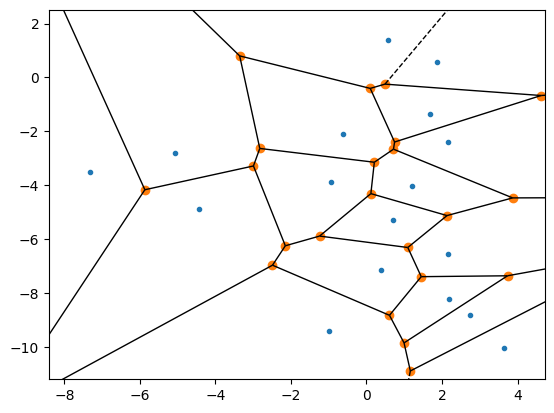

leaf_clusters 17
len(vor.point_region) 17
vor.point_region [11  9  2  3 14  6  5  0 16 10 15 12 17  8  7  4 13]
indices 11
vor.vertices[region].tolist() [[7.348271690394946, -6.443928549720327], [12.160117779648731, -4.432050272701169], [55.0397270020066, 3.8756651173274506], [-1.2423504593603143, -5.885017972738379], [1.161424922627365, -10.889429700360095]]
indices 9
vor.vertices[region].tolist() [[3.7356556862279504, -7.358257107345355], [0.9947198354224087, -9.847597679531104], [1.161424922627365, -10.889429700360095], [7.348271690394946, -6.443928549720327]]
indices 2
vor.vertices[region].tolist() [[-2.8266690475941467, -2.633738428196944], [-2.9945649503542002, -3.2839604103524302], [-5.870727059490951, -4.165972283999743], [-10.70943017731637, 10.804920154488507], [-3.359204527761485, 0.7997871983924161]]
indices 3
vor.vertices[region].tolist() [[-2.4901140211600996, -6.9653342955579545], [-9.832108929652255, -12.554832576125635], [-5.870727059490951, -4.165972283999743], [-2.99

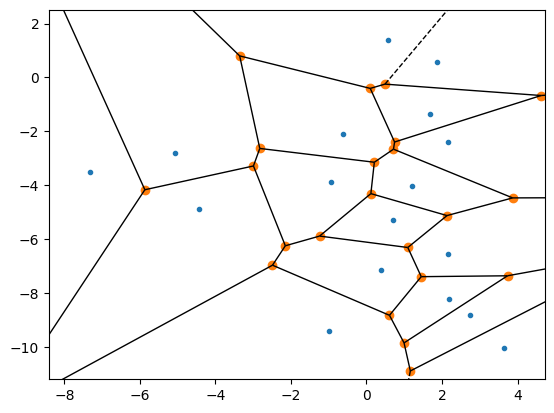

In [ ]:
# For now, it seems like d3 for computing infinite voronoi diagrams is probably the best bet because python doesn't have a library for that for some reason
# Pre-processing cluster trees to form voronoi diagram
from shapely.geometry import Polygon
from scipy.spatial import Voronoi, convex_hull_plot_2d, Delaunay
import numpy as np

# This function creates Voronoi polygons
def create_voronoi_polygons(cluster):
    leaf_clusters = []
    all_centroids = []

    # print("cluster", cluster)
    # print("cluster['content']", cluster['content'])
    # print("cluster['content'][0]", cluster['content'][0])
    def recurse(cluster):
        if isinstance(cluster['content'][0], dict):
            for subcluster in cluster['content']:
                recurse(subcluster)
        else:
            leaf_clusters.append(cluster)
            all_centroids.append([cluster['centroid_x'], cluster['centroid_y']])

    recurse(cluster)


    all_centroids = np.array(all_centroids)
    vor = Voronoi(all_centroids)
    hull = Delaunay(all_centroids)

    # testing if voronoi works properly
    import matplotlib.pyplot as plt
    fig = voronoi_plot_2d(vor)
    plt.show()
    print("leaf_clusters", len(leaf_clusters))
    print("len(vor.point_region)", len(vor.point_region))
    print("vor.point_region", vor.point_region)

    polygons = []
    for indices in vor.point_region:
        print("indices", indices)
        region = vor.regions[indices]
        print("vor.vertices[region].tolist()", vor.vertices[region].tolist())

        # TODO: risk, just not handling this and adding the vertices
        # if not region: 
        #     continue
        # if -1 in region:  # infite region that goes on forever
        #     print("region", region)
        #     polygon = hull.points[hull.convex_hull].tolist()  
        # else:
        
        polygon = vor.vertices[region].tolist()
        polygons.append(polygon)

    for i, leaf_cluster in enumerate(leaf_clusters):
        # print(polygons[i])
        leaf_cluster['polygonPoints'] = polygons[i]

    # visualie leaf_cluster polygons
    import matplotlib.pyplot as plt
    fig = voronoi_plot_2d(vor)
    plt.show()

# Main function to add polygon points to clusters
def add_polygon_points_to_clusters(cluster):
    # create Voronoi polygons for the leaf clusters
    create_voronoi_polygons(cluster)

    # This function populates polygon points up to the parent clusters
    def recurse(cluster):
        if isinstance(cluster['content'][0], dict):
            cluster['polygonPoints'] = []
            for subcluster in cluster['content']:
                recurse(subcluster)
                cluster['polygonPoints'].extend(subcluster.get('polygonPoints', []))

    recurse(cluster)

# Let's use the functions
add_polygon_points_to_clusters(trees[0])

In [ ]:
trees[0]

{'cluster_id': 100,
 'layer': 0,
 'content': [{'cluster_id': 101,
   'layer': 1,
   'content': [{'cluster_id': 104,
     'layer': 2,
     'content': [{'cluster_id': 105,
       'layer': 3,
       'content': [{'cluster_id': 107,
         'layer': 4,
         'content': [{'cluster_id': 4,
           'layer': 5,
           'content': ['7bb530adabf37316089b13690cf060c1b156b787',
            '0d3587d6d71cf7ae8e6dbfce01c29adc5cbcd569',
            '159df4c005aecff77384e075dc4baad87c4ad62f'],
           'centroid_x': 3.6326514879666667,
           'centroid_y': -10.055460929866667,
           'polygonPoints': [[7.348271690394946, -6.443928549720327],
            [12.160117779648731, -4.432050272701169],
            [55.0397270020066, 3.8756651173274506],
            [-1.2423504593603143, -5.885017972738379],
            [1.161424922627365, -10.889429700360095]]}],
         'centroid_x': 3.6326514879666667,
         'centroid_y': -10.055460929866667,
         'polygonPoints': [[7.3482716903949

In [ ]:
# Convert trees to JSON format with indentation for readability
tree_json = json.dumps(trees, indent=4, cls=Int64Encoder)

# Print the formatted tree
print(tree_json)

# Specify the file path to save the JSON data
output_file = "tree.json"

# Write the JSON data to the file
with open(output_file, "w") as file:
    json.dump(trees, file, indent=4, cls=Int64Encoder)

print("JSON file saved successfully.")

[
    {
        "cluster_id": 100,
        "layer": 0,
        "content": [
            {
                "cluster_id": 101,
                "layer": 1,
                "content": [
                    {
                        "cluster_id": 104,
                        "layer": 2,
                        "content": [
                            {
                                "cluster_id": 105,
                                "layer": 3,
                                "content": [
                                    {
                                        "cluster_id": 107,
                                        "layer": 4,
                                        "content": [
                                            {
                                                "cluster_id": 4,
                                                "layer": 5,
                                                "content": [
                                                    "7bb530adabf37316089b136

In [11]:
# PRUNING STARTS HERE
# Loading trees back in
import json

# Open the file in read mode
with open('clusters/tree_2000.json', 'r') as f:
    trees = json.load(f)  # Load the JSON data from the file

# Now, 'data' is a list of dictionaries that you can manipulate
# print(trees)

In [12]:
# Pruning the trees
def prune_single_child_clusters(cluster, depth=0):
    cluster['layer'] = depth  # Set the layer to the current depth

    # If this cluster contains sub-clusters
    if 'content' in cluster and isinstance(cluster['content'][0], dict):
        new_content = []
        for sub_cluster in cluster['content']:
            pruned = prune_single_child_clusters(sub_cluster, depth+1)
            # if the pruned sub_cluster has only one sub_cluster, replace it with its sub_cluster
            if len(pruned.get('content', [])) == 1 and isinstance(pruned['content'][0], dict):
                new_content.append(pruned['content'][0])
            else:
                new_content.append(pruned)
        cluster['content'] = new_content
    return cluster

pruned_trees = [prune_single_child_clusters(cluster) for cluster in trees]

print(json.dumps(pruned_trees, indent=4))

with open('clusters/pruned_tree_2000.json', 'w') as f:
    json.dump(pruned_trees, f, indent=4)

[
    {
        "cluster_id": 1990,
        "layer": 0,
        "content": [
            {
                "cluster_id": 1,
                "layer": 2,
                "content": [
                    "https://openalex.org/W2259938310",
                    "https://openalex.org/W2097255042",
                    "https://openalex.org/W2097259163",
                    "https://openalex.org/W2158023121",
                    "https://openalex.org/W2109034822",
                    "https://openalex.org/W2082627290",
                    "https://openalex.org/W2122910156",
                    "https://openalex.org/W2070021921",
                    "https://openalex.org/W1821918060",
                    "https://openalex.org/W2139226057",
                    "https://openalex.org/W4213354399",
                    "https://openalex.org/W1877686344",
                    "https://openalex.org/W2159821105",
                    "https://openalex.org/W2014495927",
                    "https://openal

In [ ]:
# Manually inspect simple tree
def simplify_cluster(cluster):
    # Create a new dictionary with just the cluster_id
    simple_cluster = {'cluster_id': cluster['cluster_id']}

    # If this cluster contains sub-clusters, simplify those as well
    if 'content' in cluster and isinstance(cluster['content'][0], dict):
        simple_cluster['content'] = [simplify_cluster(sub_cluster) for sub_cluster in cluster['content']]

    return simple_cluster

# Simplify each cluster in the data
simple_data = [simplify_cluster(cluster) for cluster in pruned_trees]

# Print the simplified data as a formatted JSON string
print(json.dumps(simple_data, indent=4))

with open('simple_tree.json', 'w') as f:
    json.dump(simple_data, f, indent=4)

[
    {
        "cluster_id": 100,
        "content": [
            {
                "cluster_id": 105,
                "content": [
                    {
                        "cluster_id": 4
                    },
                    {
                        "cluster_id": 10
                    }
                ]
            },
            {
                "cluster_id": 102,
                "content": [
                    {
                        "cluster_id": 2
                    },
                    {
                        "cluster_id": 110,
                        "content": [
                            {
                                "cluster_id": 1
                            },
                            {
                                "cluster_id": 16
                            },
                            {
                                "cluster_id": 14
                            },
                            {
                                "cluste

In [ ]:
# Manually inspect both papers
def get_papers_details(paper_ids, cluster_id, df):
    papers_df = df[df['paperId'].isin(paper_ids)][['paperId', 'title', 'abstract', 's2FieldsOfStudy']]
    papers_df.to_json(f'leaf_cluster_paper_inspection/papers_details_{cluster_id}.json', orient='records', indent=4)

def print_cluster_details(cluster):
    if 'content' in cluster:
        if isinstance(cluster['content'][0], dict):  # if 'content' contains clusters
            for item in cluster['content']:  # iterate over the list of clusters
                print_cluster_details(item)  # recursion call
        else:  # it's a leaf cluster
            print(cluster['cluster_id'])  # print leaf cluster id
            cluster_id = cluster['cluster_id']
            paper_ids = cluster['content']
            get_papers_details(paper_ids, cluster_id, df)
            
# Use the function like this
for cluster in trees:
    print(f"Cluster Id: {cluster['cluster_id']}")
    print_cluster_details(cluster)

Cluster Id: 100
4
10
2
1
16
14
7
0
12
3
6
9
15
8
5
13
11


# Archive

## Generate a literature review using concepts (TLDRs)

## Use knowledge base from Semantic Scholar

In [ ]:
import pandas as pd
import json

# load the data from your JSON file
with open(r'C:\Users\1kevi\Desktop\projects\Research\autoscious-carbon-capture\data_collection\output_100.json', 'r') as f:
    data = json.load(f)

# convert the data into a pandas DataFrame
df = pd.DataFrame(data)

# remove rows with null abstracts
df = df[df['abstract'].notna()]

# print out the DataFrame to verify
print(df.head())

                                    paperId  \
1  f15a2d21309f429fbec688b8aee5c7bdb66b8f40   
5  5b190c555003e154bb9038844899014425236273   
6  e24d6d882c78389a9c356b87ac46e065087549cf   
8  9496966a27c7a9176ec0a8ff6a04781caa42b7bb   
9  154b9fd69570539e90f51e1b19db944713d3bfdc   

                                                 url  \
1  https://www.semanticscholar.org/paper/f15a2d21...   
5  https://www.semanticscholar.org/paper/5b190c55...   
6  https://www.semanticscholar.org/paper/e24d6d88...   
8  https://www.semanticscholar.org/paper/9496966a...   
9  https://www.semanticscholar.org/paper/154b9fd6...   

                                               title  \
1  Renewable-integrated flexible carbon capture: ...   
5  Carbon capture and conversion using metal-orga...   
6  Climate change mitigation potential of carbon ...   
8  Cooperative carbon capture and steam regenerat...   
9  A Guideline for Life Cycle Assessment of Carbo...   

                                           

In [ ]:
import pandas as pd
import json

# load the data from your JSON file
with open(r'C:\Users\1kevi\Desktop\projects\Research\autoscious-carbon-capture\data_collection\output_50.json', 'r') as f:
    data = json.load(f)

# convert the data into a pandas DataFrame
df = pd.DataFrame(data)

# remove rows with null abstracts
# df = df[df['abstract'].notna()]
# df = df[df['tldr'].notna()]

# print out the DataFrame to verify
print(df.head())

                                     paperId  \
3   5b190c555003e154bb9038844899014425236273   
4   e24d6d882c78389a9c356b87ac46e065087549cf   
6   9496966a27c7a9176ec0a8ff6a04781caa42b7bb   
12  cfa569019717301c352aabec292a8f4d3a261553   
20  7a2197144b3a1567e814ea35fd73bd85a698681f   

                                                  url  \
3   https://www.semanticscholar.org/paper/5b190c55...   
4   https://www.semanticscholar.org/paper/e24d6d88...   
6   https://www.semanticscholar.org/paper/9496966a...   
12  https://www.semanticscholar.org/paper/cfa56901...   
20  https://www.semanticscholar.org/paper/7a219714...   

                                                title  \
3   Carbon capture and conversion using metal-orga...   
4   Climate change mitigation potential of carbon ...   
6   Cooperative carbon capture and steam regenerat...   
12  Performance-Based Screening of Porous Material...   
20  In silico discovery of covalent organic framew...   

                         

In [ ]:
# Get the first row of the DataFrame
first_row = df.iloc[0]
print(first_row)

paperId                   f15a2d21309f429fbec688b8aee5c7bdb66b8f40
url              https://www.semanticscholar.org/paper/f15a2d21...
title            Renewable-integrated flexible carbon capture: ...
abstract         To decarbonize electricity grids, CO2 capture ...
year                                                          2021
citationCount                                                   28
isOpenAccess                                                 False
fieldsOfStudy                              [Environmental Science]
embedding        {'model': 'specter@v0.1.1', 'vector': [-1.3025...
tldr                                                          None
Name: 0, dtype: object


In [ ]:
# Get the shape of the DataFrame
num_rows, num_cols = df.shape
print(f"The dataframe has {num_rows} rows and {num_cols} columns.")


The dataframe has 59 rows and 13 columns.


In [ ]:
# Have GPT3.5 generate a literature review of carbon capture using the TLDRs (significance)
%load_ext dotenv
%dotenv
import os
openai_api_key = os.getenv('OPENAI_API_KEY')
import openai

The dotenv extension is already loaded. To reload it, use:
  %reload_ext dotenv


In [ ]:
# for bulk openai message, no stream
def chat_openai(prompt="Tell me to ask you a prompt", chat_history=[]):
    # define message conversation for model
    if chat_history:
        messages = chat_history
    else:
        messages = [
            {"role": "system", "content": "You are a helpful assistant."},
        ]
    messages.append({"role": "user", "content": prompt})

    # create the chat completion
    completion = openai.ChatCompletion.create(
        model="gpt-3.5-turbo",
        messages=messages,
    )
    text_answer = completion["choices"][0]["message"]["content"]

    # updated conversation history
    messages.append({"role": "assistant", "content": text_answer})

    return text_answer, messages

## Generating Topic Metadata from S2FieldsOfStudy

In [ ]:
# Print the top 10 words for each topic
for i in range(lda.num_topics):
    print(f"Topic {i}:")
    for word, prob in lda.show_topic(i, topn=10):
        print(f"  {word}: {prob}")


In [ ]:
import pandas as pd
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import textwrap
from adjustText import adjust_text

In [ ]:
df.head()

,paperId,url,title,abstract,year,citationCount,isOpenAccess,fieldsOfStudy,s2FieldsOfStudy,embedding,tldr,citations,references,x,y,citationCount_normalized
0,17a3eb5c5fe7d6d90cde7098b5fceead18ae2d33,https://www.semanticscholar.org/paper/17a3eb5c...,Carbon capture and storage at the end of a los...,None,2021,51,True,None,"[{'category': 'Engineering', 'source': 's2-fos...","{'model': 'specter@v0.1.1', 'vector': [-0.3693...",None,[{'paperId': '0fbc075056e6f013959529ebd322e9c7...,[{'paperId': '979676198e622a6c39daefcb08f88c94...,3.260468,-8.768986,0.993184
1,f15a2d21309f429fbec688b8aee5c7bdb66b8f40,https://www.semanticscholar.org/paper/f15a2d21...,Renewable-integrated flexible carbon capture: ...,"To decarbonize electricity grids, CO2 capture ...",2021,28,False,[Environmental Science],"[{'category': 'Environmental Science', 'source...","{'model': 'specter@v0.1.1', 'vector': [-1.3025...",None,[{'paperId': '0fbc075056e6f013959529ebd322e9c7...,[{'paperId': 'ebceec9a3f0187faf186697ff05450c5...,3.993077,-7.075522,0.545278
2,a4830bc41a88ee369f08c0556360c12cf887f564,https://www.semanticscholar.org/paper/a4830bc4...,Recent advances in carbon capture storage and ...,None,2020,206,True,[Materials Science],"[{'category': 'Materials Science', 'source': '...","{'model': 'specter@v0.1.1', 'vector': [4.65861...",None,[{'paperId': '41fb6867c18f3e3a8ca70e8ce9388c51...,[{'paperId': '965050bb8475801dfcfd49509a529aa1...,1.354568,-11.164637,4.011685
3,ecacc2f192e4b881ca95749821b9d8595a81477b,https://www.semanticscholar.org/paper/ecacc2f1...,Atmospheric Carbon Capture,None,2022,0,False,None,"[{'category': 'Environmental Science', 'source...","{'model': 'specter@v0.1.1', 'vector': [2.25967...",None,[],[],2.523121,-6.680912,0.000000
4,9a722f9ec3bca95b5f86b501706d040dc968472d,https://www.semanticscholar.org/paper/9a722f9e...,Carbon mineralization pathways for carbon capt...,None,2021,28,True,[Medicine],"[{'category': 'Medicine', 'source': 'external'...","{'model': 'specter@v0.1.1', 'vector': [3.95449...",None,[{'paperId': 'cdf54c05ca1e314605992c5639c28a45...,[{'paperId': '9c96e28b7a2e5a312b203df19a8a515d...,-4.000884,-4.188164,0.545278


In [ ]:
# Trying to

In [ ]:
# Collect list of all s2FieldsOfStudy topics, corresponding PaperIds, and citation counts, and the centroid x and y values
import pandas as pd
from collections import defaultdict

# Assuming df is your DataFrame
topic_data = defaultdict(lambda: {"paperIds": [], "citationCount": 0, "xSum": 0, "ySum": 0, "count": 0})

for index, row in df.iterrows():
    for category_info in row['s2FieldsOfStudy']:
        # Get category
        category = category_info['category']
        
        # Prevent duplicates
        if category_info['source'] == 's2-fos-model':
            # Check if paperId already counted for this category
            if row['paperId'] not in topic_data[category]["paperIds"]:
                # Add paper id to category
                topic_data[category]["paperIds"].append(row['paperId'])
            
                # Cumulative citation count
                topic_data[category]["citationCount"] += row['citationCount']
                
                # Sum x and y for the average
                topic_data[category]["xSum"] += row['x']
                topic_data[category]["ySum"] += row['y']
                topic_data[category]["count"] += 1

# Compute the average x and y for each category
for category in topic_data:
    topic_data[category]["x"] = topic_data[category]["xSum"] / topic_data[category]["count"]
    topic_data[category]["y"] = topic_data[category]["ySum"] / topic_data[category]["count"]
    
    # Remove unnecessary keys
    del topic_data[category]["xSum"]
    del topic_data[category]["ySum"]
    del topic_data[category]["count"]

# Convert topic_data to DataFrame
topic_df = pd.DataFrame.from_dict(topic_data, orient='index').reset_index()

# Rename 'index' column to 'Topic'
topic_df.rename(columns={'index': 'topic'}, inplace=True)

In [ ]:
topic_df.head()

# Exporting dataframe with T-SNE coordinates
topic_df.to_json('topic_100_tsne.json', orient='records')
topic_df


,topic,paperIds,citationCount,x,y
0,Engineering,"[17a3eb5c5fe7d6d90cde7098b5fceead18ae2d33, f15...",4662,0.147016,-4.328206
1,Environmental Science,"[f15a2d21309f429fbec688b8aee5c7bdb66b8f40, eca...",5825,1.150427,-5.978143
2,Materials Science,"[a4830bc41a88ee369f08c0556360c12cf887f564, 949...",1153,-0.141871,-1.268721
3,Geology,"[9a722f9ec3bca95b5f86b501706d040dc968472d, 76a...",179,-3.053267,-4.183675
4,Chemistry,"[5b190c555003e154bb9038844899014425236273, d3b...",2008,-0.195737,-1.508678
5,Political Science,"[032b4c8ab4fed659a272afa49b821b4c6e6c19b1, 0d3...",168,2.191850,-9.891721
6,Agricultural And Food Sciences,"[522986777b3989c34f0ea37a35e1c4f4fb3d65c8, f46...",382,2.302908,-1.214205
7,Biology,"[e02f812df3cd677ec931b0ce47e10640f16968fa, ada...",5367,-2.969524,-2.371825
8,Economics,"[be026181508eca3fc0ce54bb3571f4fdbc014a8b, 79d...",181,2.885105,-8.375927
9,Business,"[bfd53c8c02171b75dba1ffa1298b59a0b027d298, b12...",96,-0.648677,-6.448681


In [ ]:
# Preprocessing for SPECTRE API
SAMPLE_TOPICS = []

for i, topic in enumerate(topic_data.keys(), start=1):
    topic_dict = {
        "paper_id": topic,
        "title": topic,
        "abstract": topic
    }
    SAMPLE_TOPICS.append(topic_dict)

SAMPLE_TOPICS

[{'paper_id': 'Engineering',
  'title': 'Engineering',
  'abstract': 'Engineering'},
 {'paper_id': 'Environmental Science',
  'title': 'Environmental Science',
  'abstract': 'Environmental Science'},
 {'paper_id': 'Chemistry', 'title': 'Chemistry', 'abstract': 'Chemistry'},
 {'paper_id': 'Materials Science',
  'title': 'Materials Science',
  'abstract': 'Materials Science'},
 {'paper_id': 'Geology', 'title': 'Geology', 'abstract': 'Geology'},
 {'paper_id': 'Agricultural And Food Sciences',
  'title': 'Agricultural And Food Sciences',
  'abstract': 'Agricultural And Food Sciences'},
 {'paper_id': 'Biology', 'title': 'Biology', 'abstract': 'Biology'},
 {'paper_id': 'Economics', 'title': 'Economics', 'abstract': 'Economics'},
 {'paper_id': 'Business', 'title': 'Business', 'abstract': 'Business'},
 {'paper_id': 'Computer Science',
  'title': 'Computer Science',
  'abstract': 'Computer Science'}]

In [ ]:
# Need to create SPECTRE em beddings for all the s2FieldsOfStudy
from typing import Dict, List
import json

import requests


URL = "https://model-apis.semanticscholar.org/specter/v1/invoke"
MAX_BATCH_SIZE = 16


def chunks(lst, chunk_size=MAX_BATCH_SIZE):
    """Splits a longer list to respect batch size"""
    for i in range(0, len(lst), chunk_size):
        yield lst[i : i + chunk_size]


SAMPLE_PAPERS = [
    {
        "paper_id": "A",
        "title": "Angiotensin-converting enzyme 2 is a functional receptor for the SARS coronavirus",
        "abstract": "Spike (S) proteins of coronaviruses ...",
    },
    {
        "paper_id": "B",
        "title": "Hospital outbreak of Middle East respiratory syndrome coronavirus",
        "abstract": "Between April 1 and May 23, 2013, a total of 23 cases of MERS-CoV ...",
    },
]


def embed(papers):
    embeddings_by_paper_id: Dict[str, List[float]] = {}

    for chunk in chunks(papers):
        # Allow Python requests to convert the data above to JSON
        response = requests.post(URL, json=chunk)

        if response.status_code != 200:
            raise RuntimeError("Sorry, something went wrong, please try later!")

        for paper in response.json()["preds"]:
            embeddings_by_paper_id[paper["paper_id"]] = paper["embedding"]

    return embeddings_by_paper_id


# if __name__ == "__main__":
all_embeddings = embed(SAMPLE_TOPICS)

# Prints { 'A': [4.089589595794678, ...], 'B': [-0.15814849734306335, ...] }
print(len(all_embeddings))
print(len(df['embedding']))

10
59


In [ ]:
# Add all_embeddings to new df and then run T-SNE
import pandas as pd
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import textwrap
from adjustText import adjust_text

In [ ]:
# Convert all_embeddings values to a list of lists
all_embeddings_list = list(all_embeddings.values())

# Convert df['embedding'] to a list of lists
df_embeddings = df['embedding'].apply(lambda x: x['vector']).tolist()

# Stack them together
combined_embeddings = np.vstack([df_embeddings, all_embeddings_list])

In [ ]:
tsne = TSNE(n_components=2, random_state=0)
embeddings_2d = tsne.fit_transform(combined_embeddings)


In [ ]:
len(df)

59

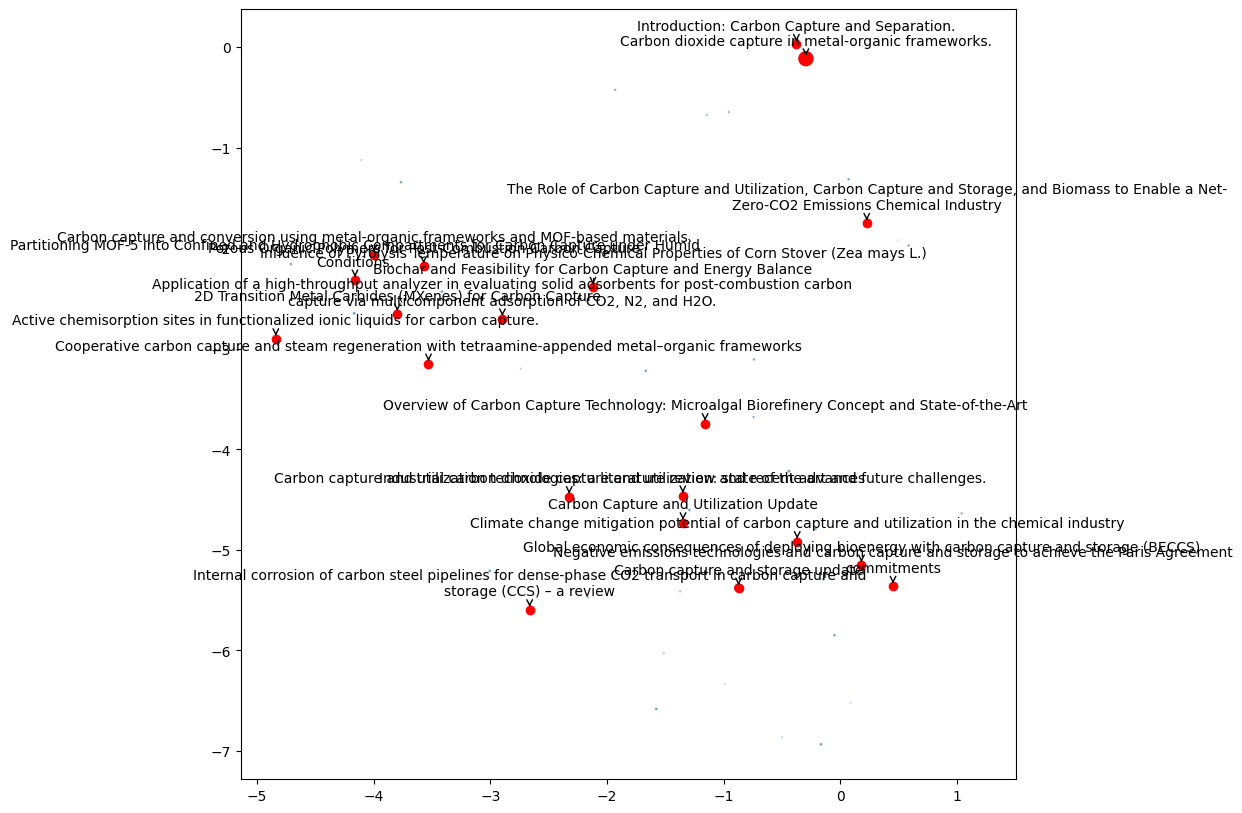

In [ ]:
# Add the 2D t-SNE coordinates to the papers DataFrame and normalize citationCount for node sizes
df['x'] = embeddings_2d[:len(df), 0]
df['y'] = embeddings_2d[:len(df), 1]
df['citationCount_normalized'] = (df['citationCount'] - df['citationCount'].min()) / (df['citationCount'].max() - df['citationCount'].min())
df['citationCount_normalized'] = df['citationCount_normalized'] * 100  # Scale to a suitable range for scatter plot node sizes

# Sort the DataFrame based on citationCount and select the top 20
df_top20 = df.nlargest(20, 'citationCount')

# Create a scatter plot of all the points with node sizes based on normalized citationCount
plt.figure(figsize=(10, 10))
plt.scatter(df['x'], df['y'], s=df['citationCount_normalized'], alpha=0.5, label='All papers')

# Highlight the top 20 papers in the plot with node sizes based on normalized citationCount
plt.scatter(df_top20['x'], df_top20['y'], s=df_top20['citationCount_normalized'], color='red', label='Top 20 papers')

# Prepare to add titles of the top 20 papers to the plot with text wrapping
texts = []
for i, row in df_top20.iterrows():
    title_wrapped = textwrap.fill(row['title'], width=100)  # Wrap text after 20 characters
    plt.scatter(row['x'], row['y'], color='red')  # This will ensure the dot is above the line
    texts.append(plt.annotate(title_wrapped, (row['x'], row['y']), textcoords="offset points", xytext=(0,10), ha='center', arrowprops=dict(arrowstyle="->")))

# Exporting dataframe with T-SNE coordinates
df.to_json('output_100_tsne.json', orient='records')

In [ ]:
# Add x and y coordinates for topics

topic_df['x'] = embeddings_2d[len(df):, 0]
topic_df['y'] = embeddings_2d[len(df):, 1]
# topic_df['citationCount_normalized'] = (df['citationCount'] - df['citationCount'].min()) / (df['citationCount'].max() - df['citationCount'].min())
# topic_df['citationCount_normalized'] = df['citationCount_normalized'] * 100  # Scale to a suitable range for scatter plot node sizes

# Exporting dataframe with T-SNE coordinates
topic_df.to_json('topic_100_tsne.json', orient='records')
topic_df

,topic,paperIds,citationCount,x,y
0,Engineering,"[f15a2d21309f429fbec688b8aee5c7bdb66b8f40, e3e...",894,1.980191,1.181053
1,Environmental Science,"[f15a2d21309f429fbec688b8aee5c7bdb66b8f40, e24...",3560,1.444582,1.283456
2,Chemistry,"[5b190c555003e154bb9038844899014425236273, 625...",1768,1.736910,1.107658
3,Materials Science,"[9496966a27c7a9176ec0a8ff6a04781caa42b7bb, cfa...",806,1.517166,1.357793
4,Geology,[76a20bec8e313ced0faf8010e6ecbe3965a9e305],30,1.806534,0.941143
5,Agricultural And Food Sciences,"[522986777b3989c34f0ea37a35e1c4f4fb3d65c8, f46...",250,1.313154,1.825582
6,Biology,"[e02f812df3cd677ec931b0ce47e10640f16968fa, ada...",5195,1.862047,1.170925
7,Economics,"[be026181508eca3fc0ce54bb3571f4fdbc014a8b, 79d...",181,2.060049,1.219957
8,Business,"[bfd53c8c02171b75dba1ffa1298b59a0b027d298, b12...",96,2.075108,1.180824
9,Computer Science,"[a747814dc1c674fe172b9bec5315da5fafd57060, 56b...",271,2.011428,1.583918


In [ ]:
print(tldr_texts)

['This review provides a comprehensive account of significant progress in the design and synthesis of MOF-based materials, including MOFs, MOF composites and MOF derivatives, and their application to carbon capture and conversion.', 'This study shows that CCU has the technical potential to lead to a carbon-neutral chemical industry and decouple chemical production from fossil resources, reducing annual GHG emissions by up to 3.5 Gt CO2-eq in 2030.', 'A family of robust tetraamine-functionalized frameworks that retain cooperativity are reported, leading to the potential for exceptional efficiency in capturing CO2 under the extreme conditions relevant to natural gas flue emissions.', 'The objective of this work is to review the current status of this new approach to multiscale screening, discuss its potential and impact on the field of materials screening, and highlight the challenges that limit its application.', 'A genetic algorithm is developed to tune the charge equilibration method 

In [ ]:
prompt = "I am a college student who is a beginner in carbon capture. Write a literature review of carbon capture using the TLDRs (significance) of papers: " + str(tldr_texts)

In [ ]:
res = chat_openai(prompt)

In [ ]:
res

('Carbon capture and conversion (CCU) has been identified as a potential solution to reduce global CO2 emissions. One way to achieve this is through the use of metal-organic framework-based materials (MOFs) for carbon capture. A comprehensive review of MOFs and their derivatives reveals significant progress in their design and synthesis. MOFs have great potential for application in CCU due to their high surface area, tunability, and selectivity.\n\nAnother study shows that CCU has technical potential to lead to a carbon-neutral chemical industry, reducing annual GHG emissions by up to 3.5 Gt CO2-eq by 2030. This could potentially decouple chemical production from fossil resources, crucial for mitigating climate change.\n\nA family of robust tetraamine-functionalized frameworks has been developed that effectively captures CO2 under extreme conditions. This opens up the potential for exceptional efficiency in CCU in natural gas flue emissions.\n\nThe use of genetic algorithms has facilit

In [ ]:
# Get 'tldr' column as a Series
tldr_series = df['tldr']

# Extract the 'text' from each 'tldr' dictionary in the Series
tldr_texts = [item['text'] if item is not None else None for item in tldr_series]


## Manual Inspection of Output for Manual Hierarchical Clustering

In [2]:
import json

# Load the input data
with open('t-sne/output_100_tsne.json', 'r') as infile:
    data = json.load(infile)

# Extract desired fields
new_data = []
for entry in data:
    paperId = entry.get('paperId', None)
    title = entry.get('title', None)
    abstract = entry.get('abstract', None)
    
    # Build new data entry
    if paperId is not None and title is not None and abstract is not None:
        new_data.append({
            'paperId': paperId,
            'title': title,
            # 'abstract': abstract
        })

# Write to output file
with open('t-sne/output_100_tsne_manual_inspection_id_titles_only.json', 'w') as outfile:
    json.dump(new_data, outfile, indent=4)


## Generating paper topics from title and abstract

In [70]:
import pandas as pd
import json

# load the data from your JSON file
with open(r'C:\Users\1kevi\Desktop\projects\Research\autoscious-carbon-capture\knowledge_base\t-sne\output_100_tsne.json', 'r') as f:
    data = json.load(f)

# convert the data into a pandas DataFrame
df = pd.DataFrame(data)

# print out the DataFrame to verify
print(df.head())

                                    paperId  \
0  17a3eb5c5fe7d6d90cde7098b5fceead18ae2d33   
1  f15a2d21309f429fbec688b8aee5c7bdb66b8f40   
2  a4830bc41a88ee369f08c0556360c12cf887f564   
3  ecacc2f192e4b881ca95749821b9d8595a81477b   
4  9a722f9ec3bca95b5f86b501706d040dc968472d   

                                                 url  \
0  https://www.semanticscholar.org/paper/17a3eb5c...   
1  https://www.semanticscholar.org/paper/f15a2d21...   
2  https://www.semanticscholar.org/paper/a4830bc4...   
3  https://www.semanticscholar.org/paper/ecacc2f1...   
4  https://www.semanticscholar.org/paper/9a722f9e...   

                                               title  \
0  Carbon capture and storage at the end of a los...   
1  Renewable-integrated flexible carbon capture: ...   
2  Recent advances in carbon capture storage and ...   
3                         Atmospheric Carbon Capture   
4  Carbon mineralization pathways for carbon capt...   

                                           

In [29]:
# # Testing top 3 n-grams from title, embedding each n-gram, and then clustering each n-gram
# from sklearn.feature_extraction.text import TfidfVectorizer
# from nltk.corpus import stopwords
# import numpy as np

# # List of English stop words
# stop_words = list(stopwords.words('english'))

# # Create the transform
# vectorizer = TfidfVectorizer(ngram_range=(2,3), stop_words=stop_words)

# # Tokenize, build vocab and calculate TF-IDF
# tfidf_matrix = vectorizer.fit_transform(df['text'])

In [31]:
# # Define a function to extract top 3 words with the highest TF-IDF score in a given document
# def top_words(doc_index):
#     feature_index = tfidf_matrix[doc_index,:].nonzero()[1]
#     tfidf_scores = zip(feature_index, [tfidf_matrix[doc_index, x] for x in feature_index])
    
#     # Corresponding feature names and scores
#     words_scores = [(vectorizer.get_feature_names_out() [i], s) for (i, s) in tfidf_scores]
#     words_scores = sorted(words_scores, key = lambda x: x[1], reverse=True)
    
#     return words_scores

In [32]:
# # Apply the function to each row index in the dataframe
# df['top_words'] = [top_words(i) for i in range(tfidf_matrix.shape[0])]

In [33]:
# df[['title', 'text', 'top_words']]
# df[['title', 'text', 'top_words']].to_json('topics/top_words.json', orient='records', lines=True, indent=2)

In [ ]:
# # Testing reranking of words based on similarity to document embedding via specter & ada

# from transformers import AutoTokenizer, AutoModel
# import torch

# # models
# EMBEDDING_MODEL = "text-embedding-ada-002"

# tokenizer = AutoTokenizer.from_pretrained('allenai/specter')
# model = AutoModel.from_pretrained('allenai/specter')

# def calculate_embedding(text):
#     inputs = tokenizer(text, padding=True, truncation=True, max_length=512, return_tensors="pt")
#     with torch.no_grad():
#         return model(**inputs)[0].mean(dim=1).numpy()

# # Calculate document embeddings
# # df['document_embedding'] = df['text'].apply(calculate_embedding)


In [ ]:
# # Exploring LDA2Vec
# import pandas as pd
# from sklearn.feature_extraction.text import CountVectorizer
# from lda2vec import LDA2Vec
# from transformers import AutoTokenizer, AutoModel
# import torch
# import numpy as np

# # Load your data
# df = pd.read_csv('your_data.csv')

# # Preprocess your text data
# # This step will depend on the specifics of your data
# # For example, you might need to remove stop words, perform lemmatization, etc.

# # Set up SPECTER model for embeddings
# tokenizer = AutoTokenizer.from_pretrained('allenai/specter')
# model = AutoModel.from_pretrained('allenai/specter')

# def calculate_embedding(text):
#     inputs = tokenizer(text, padding=True, truncation=True, max_length=512, return_tensors="pt")
#     with torch.no_grad():
#         return model(**inputs)[0].mean(dim=1).numpy()

# # Generate word embeddings using SPECTER
# df['embeddings'] = df['text'].apply(calculate_embedding)

# # Prepare data for LDA2Vec
# # This involves creating a count matrix of your text data
# vectorizer = CountVectorizer()
# counts = vectorizer.fit_transform(df['text'])

# # Create an LDA2Vec model
# lda2vec = LDA2Vec(n_topics=20, n_words=10000)

# # Fit the LDA2Vec model
# lda2vec.fit(counts, df['embeddings'].tolist())

# # Now you can use the lda2vec model to explore topics in your text
# # For example, you can look at the most common words in each topic


In [55]:
# # Trying Guided LDA
# from sklearn.feature_extraction.text import CountVectorizer
# from sklearn.decomposition import LatentDirichletAllocation
# from sklearn.cluster import KMeans
# from transformers import AutoTokenizer, AutoModel
# import torch
# import pandas as pd
# import numpy as np
# from nltk.util import ngrams
# import nltk
# nltk.download('stopwords')

# # Initialize SPECTER model
# tokenizer = AutoTokenizer.from_pretrained('allenai/specter')
# model = AutoModel.from_pretrained('allenai/specter')

# # Function to calculate embeddings
# def calculate_embedding(text):
#     inputs = tokenizer(text, padding=True, truncation=True, max_length=512, return_tensors="pt")
#     with torch.no_grad():
#         return model(**inputs)[0].mean(dim=1).numpy()

# # Calculate document embeddings
# # df['document_embedding'] = df['text'].apply(calculate_embedding)

# # Tokenize text and create bigrams

# # Load the set of English stop words
# stop_words = set(stopwords.words('english'))

# df['tokens'] = df['text'].apply(lambda x: [word for word in x.split() if word not in stop_words])
# df['bigrams'] = df['tokens'].apply(lambda x: [' '.join(gram) for gram in ngrams(x, 2) if all(word not in stop_words for word in gram)])

# unique_tokens = pd.Series([item for sublist in df['tokens'].tolist() for item in sublist]).unique()
# unique_bigrams = pd.Series([item for sublist in df['bigrams'].tolist() for item in sublist]).unique()

# word_embeddings = {word: calculate_embedding(word) for word in unique_tokens}
# bigram_embeddings = {bigram: calculate_embedding(bigram) for bigram in unique_bigrams}


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\1kevi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [62]:
# word_embeddings = {word: word_embeddings[word].reshape(1, -1) for word in word_embeddings}
# bigram_embeddings = {bigram: bigram_embeddings[bigram].reshape(1, -1) for bigram in bigram_embeddings}

# print(word_embeddings['carbon'].shape)
# print(bigram_embeddings['carbon capture'].shape)

(1, 768)
(1, 768)


In [64]:
# # Cluster words and bigrams based on embeddings
# # Cluster words and bigrams based on embeddings
# word_clusters = KMeans(n_clusters=20).fit(np.array(list(word_embeddings.values())).reshape(-1, 768))
# bigram_clusters = KMeans(n_clusters=20).fit(np.array(list(bigram_embeddings.values())).reshape(-1, 768))


c:\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [65]:

# # Create seed topics based on clusters
# seed_topics = {word: word_clusters.labels_[i] for i, word in enumerate(word_embeddings.keys())}
# seed_topics.update({bigram: bigram_clusters.labels_[i] for i, bigram in enumerate(bigram_embeddings.keys())})

In [ ]:
# print(seed_topics)
# # Need to verify if the topics and words under them are even good.

In [67]:
# seed_topics_grouped = {}

# for word, topic in seed_topics.items():
#     if topic in seed_topics_grouped:
#         seed_topics_grouped[topic].append(word)
#     else:
#         seed_topics_grouped[topic] = [word]


In [ ]:
# seed_topics_grouped

In [51]:
# from numpy import dot
# from numpy.linalg import norm

# def cosine_similarity(a, b):
#     a = a.flatten()  # Add this line
#     b = b.flatten()  # Add this line
#     return dot(a, b) / (norm(a) * norm(b))


In [ ]:
# # Running GuidedLDA
# from guidedlda import GuidedLDA

# # Vectorize your text data
# vectorizer = CountVectorizer(vocabulary=seed_topics.keys())
# X = vectorizer.fit_transform(df['text'])

# # Create a seed topics matrix
# seed_topics_matrix = np.zeros((40, len(seed_topics)))

# for word, topic in seed_topics.items():
#     seed_topics_matrix[topic, vectorizer.vocabulary_[word]] = 1

# # Run Guided LDA
# model = GuidedLDA(n_topics=40, n_iter=100, random_state=7, refresh=20)
# model.fit(X, seed_topics=seed_topics_matrix)

# # Get the topic-word and document-topic distributions
# topic_word_distributions = model.topic_word_
# document_topic_distributions = model.transform(X)

In [40]:
# def get_top_words_spectre(row):
#     # Get the document embedding and flatten it
#     document_embedding = row['document_embedding_ada'].flatten()
    
#     top_words_spectre = []
#     for word, _ in row['top_words']:
#         word_embedding = calculate_embedding(word)
#         word_embedding = word_embedding.flatten()  # Flatten the word embedding
#         similarity = cosine_similarity(word_embedding, document_embedding)
#         top_words_spectre.append((word, similarity))
    
#     # Sort the words by their similarity to the document embedding
#     top_words_spectre.sort(key=lambda x: x[1], reverse=True)
    
#     return top_words_spectre

In [41]:
# # 21 min on 100 papers and all their n grams
# df['top_words_spectre'] = df.apply(get_top_words_spectre, axis=1)

In [42]:

# df[['title', 'text', 'top_words_spectre']].to_json('topics/top_words_spectre.json', orient='records', lines=True, indent=2)

In [ ]:
# # Use an embedding to transform each of these words? 
# from sentence_transformers import SentenceTransformer
# import numpy as np

# model = SentenceTransformer('sentence-transformers/miniLM-L6-H384-uncased')

# # Assume 'top_words' is a list of your top words for each paper
# top_words = ['carbon', 'capture', 'storage', 'renewable', 'energy']

# word_embeddings = {}
# for word in top_words:
#     word_embeddings[word] = model.encode([word])[0]

# # Now 'word_embeddings' is a dictionary that maps words to their corresponding embeddings

In [72]:
df.head()

,paperId,url,title,abstract,year,citationCount,isOpenAccess,fieldsOfStudy,s2FieldsOfStudy,embedding,tldr,citations,references,x,y,citationCount_normalized
0,17a3eb5c5fe7d6d90cde7098b5fceead18ae2d33,https://www.semanticscholar.org/paper/17a3eb5c...,Carbon capture and storage at the end of a los...,None,2021,51,True,None,"[{'category': 'Engineering', 'source': 's2-fos...","{'model': 'specter@v0.1.1', 'vector': [-0.3693...",None,[{'paperId': '0fbc075056e6f013959529ebd322e9c7...,[{'paperId': '979676198e622a6c39daefcb08f88c94...,3.260468,-8.768986,0.993184
1,f15a2d21309f429fbec688b8aee5c7bdb66b8f40,https://www.semanticscholar.org/paper/f15a2d21...,Renewable-integrated flexible carbon capture: ...,"To decarbonize electricity grids, CO2 capture ...",2021,28,False,[Environmental Science],"[{'category': 'Environmental Science', 'source...","{'model': 'specter@v0.1.1', 'vector': [-1.3025...",None,[{'paperId': '0fbc075056e6f013959529ebd322e9c7...,[{'paperId': 'ebceec9a3f0187faf186697ff05450c5...,3.993077,-7.075522,0.545278
2,a4830bc41a88ee369f08c0556360c12cf887f564,https://www.semanticscholar.org/paper/a4830bc4...,Recent advances in carbon capture storage and ...,None,2020,206,True,[Materials Science],"[{'category': 'Materials Science', 'source': '...","{'model': 'specter@v0.1.1', 'vector': [4.65861...",None,[{'paperId': '41fb6867c18f3e3a8ca70e8ce9388c51...,[{'paperId': '965050bb8475801dfcfd49509a529aa1...,1.354568,-11.164637,4.011685
3,ecacc2f192e4b881ca95749821b9d8595a81477b,https://www.semanticscholar.org/paper/ecacc2f1...,Atmospheric Carbon Capture,None,2022,0,False,None,"[{'category': 'Environmental Science', 'source...","{'model': 'specter@v0.1.1', 'vector': [2.25967...",None,[],[],2.523121,-6.680912,0.000000
4,9a722f9ec3bca95b5f86b501706d040dc968472d,https://www.semanticscholar.org/paper/9a722f9e...,Carbon mineralization pathways for carbon capt...,None,2021,28,True,[Medicine],"[{'category': 'Medicine', 'source': 'external'...","{'model': 'specter@v0.1.1', 'vector': [3.95449...",None,[{'paperId': 'cdf54c05ca1e314605992c5639c28a45...,[{'paperId': '9c96e28b7a2e5a312b203df19a8a515d...,-4.000884,-4.188164,0.545278


In [73]:
# Using GPT3.5 to generate topics

# imports
%load_ext dotenv
%dotenv
import os
# openai_api_key = os.getenv('OPENAI_API_KEY')
openai_api_key = os.getenv('OPENAI_GPT4_API_KEY')
import openai

# models
EMBEDDING_MODEL = "text-embedding-ada-002"
GPT_MODEL = "gpt-3.5-turbo"
# GPT_MODEL = "gpt-4"

# for bulk openai message, no stream
def chat_openai(prompt="Tell me to ask you a prompt", chat_history=[]):
    # define message conversation for model
    if chat_history:
        messages = chat_history
    else:
        messages = [
            {"role": "system", "content": "You are ChatGPT, a large language model trained by OpenAI. Answer as concisely as possible."},
        ]
    messages.append({"role": "user", "content": prompt})

    # create the chat completion
    completion = openai.ChatCompletion.create(
        model="gpt-3.5-turbo",
        messages=messages,
        temperature=0
    )
    text_answer = completion["choices"][0]["message"]["content"]

    # updated conversation history
    messages.append({"role": "assistant", "content": text_answer})

    return text_answer, messages

The dotenv extension is already loaded. To reload it, use:
  %reload_ext dotenv


In [163]:
# existing_themes = 'Renewable integration, carbon capture, Clean energy transition, Operational flexibility, Cost-effective CO2 reduction, carbon storage, lost decade'

# paper = "titled '" + df.iloc[0]["title"] + "'"
# if df.iloc[0]["abstract"]:
#     paper += "with the following abstract: " + df.iloc[0]["abstract"]

# prompt = f'''
# Paper: {paper} \n Task: Given the paper title and abstract above, determine at most 5 themes for a researcher whose goal is to eventually make impactful discoveries and experiments. \n Rules: Do not output any theme that is beyond what is given in the paper. Be as concise (less than 5 words), clear, and correct as possible. Do not make up anything not apparent from the paper. \n Use themes from other papers only if the paper mentions them: {existing_themes}. 

# Your output should be of the following format: Theme1, Theme2, Theme3, Theme4, Theme5
# '''